## Librerie

In [1]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv
from dotmap import DotMap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keplergl
import pickle
from cmath import isnan
from concurrent.futures import process
import functools
import os

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

C:\Users\Jacopo COSSU\AppData\Local\Temp/ipykernel_13448/1847361299.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


### Indice delle query di Geovistory

In [2]:
"""
import glob
import os
indice_query={}
for filename in glob.glob("geovistory_query_exports\*.json"):
   indice_query[filename[(filename.find('\\')+1):(filename.find('.'))]] = filename
"""


def indice_file(directory):
    indice = {}
    for filename in os.listdir(directory):
        indice[filename[:filename.find('.')]] = directory+'/'+filename
    return indice


In [3]:
indice = indice_file('geovistory_query_exports')

## Funzioni

In [4]:
# string cleaning
## pulizia delle stringhe

def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a  

In [5]:
# string cleanup and reduction to lower case
## pulizi delle stringhe e riduzione a lower case

def str_normalization(string):
    if type(string) == str and (string != ''):
        string = string.strip().replace('\xa0', '').replace('  ', ' ').lower()
    return string

In [6]:
#introduction of np.nan values
## introduzione dei valori np.nan

def nan_compiler(df):
        return df.replace('', np.nan, inplace=True)

In [7]:
# year calculation (average)
# calcolo dell'anno (medio)

def date(r_col):

    lista = []
    for v in r_col['values']:
        if v.value.timePrimitive:
            lista.append(int(v.value.timePrimitive.label[:4]))

    if len(lista) >= 1:
        return int(np.rint(np.mean(lista)))
    else:
        return np.nan


In [8]:
# time-spen definition (average year: beginning, at a certain time, end)
## sintesi time-spen (anno medio: begin, at some time, end)

def datatio(r_col_begin, r_col_someTime, r_col_end, element):

    begin, some_time, end = date(r_col_begin), date(r_col_someTime), date(r_col_end)
    element+= [begin, some_time, end]

    return(element)

In [9]:
# elminazione delle dupplicazioni in leggenda
###  https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [10]:
# processetti dataframe generator

def processetti_generator(file):

    file = file
    with open(file, encoding='utf-8') as json_file:
        data_processetti = json.load(json_file)
    dm_processetti = DotMap(data_processetti)
    dm_procesetti_rows = dm_processetti.rows
    # Processetti list = psl
    psl = [['volume', 'section', 'number_archival_units', 'pk_processetto', 'enquiry', 'pk_person', 'motivation_type',
           'start_date', 'end_date', 'anno', 'id_union', 'number_union']]

    for r in dm_procesetti_rows:  # r for row
        element = []
        # volume
        element += ['-'.join([v.entity_label for v in r.col_0.entities])
                    if len(r.col_0.entities) >= 1 else np.nan]
        # sezione (unità archivistica)
        element += [clean_up_str(r.col_1.entities[0].entity_label)]
        # numero di section per enquiry
        element += [len(r.col_1.entities)]
        # enquiry
        element += [r.col_2.entity.pk_entity,
                    clean_up_str(r.col_2.entity.entity_label)]
        # pk_person     ## Integrazione (08/08/2022) -- garantirà un miglior allineamento
        element += [r.col_6.entities[0].pk_entity if r.col_6.entities else np.nan]
        # motivation type
        element += [clean_up_str('; '.join([v.entity_label for v in r.col_3.entities]))
                    if len(r.col_3.entities) >= 1 else np.nan]
        # arco e anno processetto
        valor = []
        if len(r.col_4['values']) == 0:
            element += [np.nan, np.nan, np.nan]
        else:
            for v in r.col_4['values']:
                valor.append(int(v.value.timePrimitive.label[:4]))
            element += [r.col_4['values'][0]['value'].timePrimitive.label[:10], r.col_4[
                'values'][len(r.col_4['values'])-1]['value'].timePrimitive.label[:10], round(np.mean(valor))]
        # union
        if len(r.col_5.entities) == 1:
            element += [r.col_5.entities[0].pk_entity, len(r.col_5.entities)]
        elif len(r.col_5.entities) > 1:
            element += ['-'.join([str(v.pk_entity) for v in r.col_5.entities])
                        if len(r.col_5.entities) >= 1 else np.nan, len(r.col_5.entities)]
        else:
            element += [np.nan, 0]

        psl.append(element)

    return pd.DataFrame(psl[1:], columns=psl[0])


In [11]:
# persons dataframe generator - according to role or quality (applicant, witness, defunct)

def persons_generator(file, quality=''):
    file = file
    quality = quality
    with open(file, encoding='utf-8') as json_file:
        data = json.load(json_file)

    dm = DotMap(data)
    dm_r = dm.rows

    if ('tes' or 'wit') in quality:
        quality = 'testimone'
    elif ('ric' or 'req' or 'app' or 'inv') in quality:
        quality = 'richiedente'
    elif ('def' or 'dec') in quality:
        quality = 'defunto'

    if (quality == 'testimone') or (quality == 'richiedente'):
        # Richiedenti list = rl
        lista = [['pk_processetto',  'pk_person', 'person', 'qualità',
                  'genere', 'origini', 'professioni', 'anno_nascita']]

        for r in dm_r:
            for el in r.col_0.entities:
                element = []
                element += [el.pk_entity]
                # pk_person, person, qualità, genere
                element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), quality, (
                    r.col_2.entities[0].entity_label if len(r.col_2.entities) > 0 else np.nan)]
                # origini
                element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities))
                            if len(r.col_3.entities) >= 1 else np.nan]
                # professioni
                element += ['; '.join(e.entity_label for e in r.col_5.entities)
                            if len(r.col_5.entities) >= 1 else np.nan]
                # Anno di nascita
                element += [date(r.col_4)]
                lista.append(element)

    elif quality == 'defunto':
        lista = [['pk_person', 'person', 'qualità', 'genere', 'origini', 'professioni', 'anno_nascita', 'anno_morte',
                  'luogo_morte', 'id_union', 'union_count', 'type_union', 'pk_person(partner)', 'partner', 'pk_processetto']]
        for r in dm_r:
            element = []
            # pk_person, person, qualità, genere, origini, professioni
            element += [r.col_0.entity.pk_entity, clean_up_str(r.col_0.entity.entity_label), quality, (r.col_1.entities[0].entity_label if len(r.col_1.entities) > 0 else np.nan), (
                ('; '.join(e.entity_label for e in r.col_2.entities)) if len(r.col_2.entities) >= 1 else np.nan), ('; '.join(e.entity_label for e in r.col_4.entities) if len(r.col_4.entities) >= 1 else np.nan)]
            # anno_nascita
            element += [date(r.col_3)]
            # anno_morte, luogo_morte
            element += [date(r.col_6), ('; '.join(e.entity_label for e in r.col_7.entities)
                                        if len(r.col_7.entities) >= 1 else np.nan)]
            # union, conteggio_unioni, tipo unione
            element += ['-'.join([str(v.pk_entity) for v in r.col_8.entities]) if len(r.col_8.entities) >= 1 else np.nan, len(r.col_8.entities), (
                '; '.join(e.entity_label for e in r.col_9.entities) if len(r.col_9.entities) >= 1 else np.nan)]
            # pk_person(partner), partner
            # riscrivi
            id_part, part = [], []
            for e in r.col_10.entities:
                if e.pk_entity != r.col_0.entity.pk_entity:
                    id_part.append(e.pk_entity)
                    part.append(clean_up_str(e.entity_label))
            element += [('-'.join(str(e) for e in id_part) if len(id_part) >=
                         1 else np.nan), ('; '.join(part) if len(part) >= 1 else np.nan)]
            # pk_processetto
            element += ['-'.join([str(v.pk_entity) for v in r.col_11.entities])
                        if len(r.col_11.entities) >= 1 else np.nan]
            lista.append(element)

    return pd.DataFrame(lista[1:], columns=lista[0])


In [12]:
def persons_name_generator(file):
    file = file 
    with open(file, encoding='utf-8') as json_file:
        data_name = json.load(json_file)
    dmperson_name = DotMap(data_name)
    dmperson_name_rows = dmperson_name.rows

    pnl = [['pk_person', 'person', 'cognome', 'cognome_count', 'titolo_rispetto', 'titolo_profesisonale']]

    for r in dmperson_name_rows:
        element = []
        element += [r.col_0.entity.pk_entity, r.col_0.entity.entity_label, clean_up_str('; '.join(c.entity_label for c in r.col_1.entities)), len(r.col_1.entities) , str_normalization('; '.join(tr.entity_label for tr in r.col_2.entities)),
        str_normalization('; '.join(tp.entity_label for tp in r.col_3.entities))]
        pnl.append(element)

    return pd.DataFrame(pnl[1:], columns=pnl[0])
    
    


In [13]:
def localisation_generator(file):
    file = file
    with open(file, encoding='utf-8') as json_file:
        data_localisation = json.load(json_file)
    dmlocalisation = DotMap(data_localisation)
    dmlocalisation_rows = dmlocalisation.rows

    # Localisation list = ll
    ll = [['id_localisation', 'pk_person', 'person', 'geographical_place', 'GP_type', 'lat', 'lon', 'localisation_type', 'begin', 'at_some_time', 'end', 'occours_before', 'occours_after']]
    for r in dmlocalisation_rows:
        element = []
        # id_localisatio, pk_person, person, geo_place + (id), 
        ## valuta la comodità di tenere separato l'ID geographical Place, geographical place, type, coordinate (x,y), localization type 
        element += [str(r.col_0.entity.pk_entity), r.col_1.entities[0].pk_entity, clean_up_str(r.col_1.entities[0].entity_label), (r.col_2.entities[0].entity_label + f' ({ r.col_2.entities[0].pk_entity})')  if len(
            r.col_2.entities)>0 else np.nan, r.col_10.entities[0].entity_label if len(r.col_10.entities)>=1 else np.nan]
        if len(r.col_12['values'])>0:    
            element += [r.col_12['values'][0].value.geometry.geoJSON.coordinates[1], r.col_12['values'][0].value.geometry.geoJSON.coordinates[0]]
        else:
            element +=[np.nan, np.nan]
        element += [r.col_11.entities[0].entity_label if len(r.col_11.entities)>0 else np.nan]
        # Begin
        element += [round(np.mean([int(r.col_3['values'][0].value.timePrimitive.label[:4]), int(r.col_4['values'][0].value.timePrimitive.label[:4])])) if (len(r.col_3['values'])>0) and (len(r.col_4['values'])>0) else int(
            r.col_3['values'][0].value.timePrimitive.label[:4]) if (len(r.col_3['values'])>0) else int(r.col_4['values'][0].value.timePrimitive.label[:4]) if len(r.col_4['values'])>0 else np.nan]
        # At some time within
        element += [int(r.col_5['values'][0].value.timePrimitive.label[:4]) if len(r.col_5['values'])>0 else np.nan]
        # End
        element += [round(np.mean([int(r.col_6['values'][0].value.timePrimitive.label[:4]), int(r.col_7['values'][0].value.timePrimitive.label[:4])])) if (len(r.col_6['values'])>0) and (len(r.col_7['values'])>0) else int(
            r.col_6['values'][0].value.timePrimitive.label[:4]) if (len(r.col_6['values'])>0) else int(r.col_7['values'][0].value.timePrimitive.label[:4]) if len(r.col_7['values'])>0 else np.nan]    
        # Occours before
        element += [[ str(v.pk_entity) for v in r.col_8.entities] if len(r.col_8.entities)>0 else np.nan]
        ## element += ['-'.join(str(v.pk_entity) for v in r.col_8.entities) if len(r.col_8.entities)>0 else np.nan]
        # Occours after
        element += [[str(v.pk_entity) for v in r.col_9.entities] if len(r.col_9.entities)>0 else np.nan]
        ## element += ['-'.join(str(v.pk_entity) for v in r.col_9.entities) if len(r.col_9.entities)>0 else np.nan]
        
        ll.append(element)

    return pd.DataFrame(ll[1:], columns=ll[0])

In [14]:
def occuparionEvent_generator(file):
    file = file
    with open(file, encoding='utf-8') as json_file:
        data = json.load(json_file)
    dm_data = DotMap(data)
    dm_data_r = dm_data.rows
    
    # Occupation event list = oel
    oel = [['pk_person', 'person', 'id_occup_event', 'occupation', 'begin', 'at_some_time', 'end', 'occours_before', 'count_OB', 'occours_after', 'count_OA']]
    for r in dm_data_r:
        element = []
        # pk_person, person
        if len(r.col_0.entities)>0:
            element += [str(r.col_0.entities[0].pk_entity) , clean_up_str(r.col_0.entities[0].entity_label)]
        else:
            element += [np.nan, np.nan]
        # id occupation event, occupation
        element += [r.col_1.entity.pk_entity, r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan]
        # Begin, At some time within, End
        datatio(r.col_3, r.col_5, r.col_4, element)
        '''
        # Begin
        # riscrivi
        if len(r.col_3['values'])==1:
            element += [int(r.col_3['values'][0].value.timePrimitive.label[:4])]
        elif len(r.col_3['values'])>1:
            element += [round(np.mean([int(r.col_3['values'][0].value.timePrimitive.label[:4]), int(r.col_3['values'][1].value.timePrimitive.label[:4])]))]
        else:
            element += [np.nan]
        
        
        # At some time within
        element += [int(r.col_5['values'][0].value.timePrimitive.label[:4]) if len(r.col_5['values'])!=0 else np.nan]

        # End
        ## riscrivi
        if len(r.col_4['values'])==1:
            element += [int(r.col_4['values'][0].value.timePrimitive.label[:4])]
        elif len(r.col_4['values'])>1:
            element += [round(np.mean([int(r.col_4['values'][0].value.timePrimitive.label[:4]), int(r.col_4['values'][1].value.timePrimitive.label[:4])]))]
        else:
            element += [np.nan]
        '''
        # Occours before, conteggio (OB),  Occours after, conteggio(OA)
        element += ['-'.join(str(v.pk_entity) for v in r.col_6.entities) if len(r.col_6.entities)>0 else np.nan, len(r.col_6.entities), '-'.join(str(v.pk_entity) for v in r.col_7.entities) if len(r.col_7.entities)>0 else np.nan, len(r.col_7.entities)]
        oel.append(element)
        
    return pd.DataFrame(oel[1:], columns=oel[0])
    



In [15]:
def activityDomains_generator(file):
    file = file
    with open(file, encoding='utf-8') as json_file:
        data_domain = json.load(json_file)

    dmd = DotMap(data_domain)
    dmd_r = dmd.rows

    # act_domain list = adl
    adl = [['id_occupation', 'occupation', 'broder_occupation', 'activity_domain', 'broder_activity']]
    for row in dmd_r:
        element = []
        element += [row.col_0.entity.pk_entity, row.col_0.entity.entity_label]
        if len(row.col_1.entities)>=1:
            ocupations=[]
            for e in row.col_1.entities:
                ocupations +=[e.entity_label]
            element += [ocupations]
        else:
            element += [np.nan]
        if row.col_2.entities:
            activity=[]
            for e in row.col_2.entities:
                activity += [e.entity_label]
            element += [activity]
        else:
            element += [np.nan]
        if row.col_3.entities:
            activity_bt=[]
            for e in row.col_3.entities:
                activity_bt += [clean_up_str(e.entity_label)]
            element += [activity_bt]
        else:
            element += [np.nan]
        
        adl.append(element)
    

    return pd.DataFrame(adl[1:], columns=adl[0])  
    

-------------------------------------

## Appertura e ispezione dei file 

### Processetti


In questa sezione i dati vengono ispezionati una prima volta. Vengono importati gli _output_ scaricati da Geovistory 

I file contengono il risultato di un'interrogazione fatta in Geovistory, una tabella del dominio Analysis, con lo stesso nome, fatta nella data indicata nel nome del file. Se si vuole utilizzare un nuovo file, contenente dati aggiornati, va scaricarlo da Geovistory, caricato nella cartella *geovistory_query_exports* e indicato l'indirizzo corretto entro la funzione `processetti_generator()`.

[...]

In [16]:
display((processetti := processetti_generator('geovistory_query_exports/nb_overwiev_processetti_20220510.json')).head())

,volume,section,number_archival_units,pk_processetto,enquiry,pk_person,motivation_type,start_date,end_date,anno,id_union,number_union
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),1006422.0,Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",999599.0,Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",1006794.0,Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),1006856.0,Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0
4,EM 05,Processetto di Ortensia di Leonardo Verona (da...,1,1007355,Ortensia di Leonardo Verona (da Venzone),1007216.0,Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0


In [17]:
# processetto overview
processetti.describe(exclude=np.number)

,volume,section,enquiry,motivation_type,start_date,end_date,id_union
count,3797,3797,3797,3792,3788,3788,616
unique,29,3695,3782,12,2237,2257,613
top,EM 07,Processetto di Margherita di Matteo Paulini e ...,(no label),Stato libero di “foresto”,1632-02-21,1632-02-21,1079309
freq,503,3,11,3009,12,12,2


In [18]:
processetti.section.value_counts().sort_values(ascending=False)

Processetto di Margherita di Matteo Paulini e di Bartolomeo Evangelista Giustinelli (da Bornato)                 3
Processetto di Vincenzo di Giovanni Nante (da Bologna, mercante)                                                 2
Processetto di Anna di Giovanni Mancini (teutonica) e Gregorio di Andrea (da Augusta, pistor)                    2
Processetto di Giacomo di Battista Plano (da Rocca Pietore, tesser) e Sabata di Giovanni Trius (dalla Carnia)    2
Processetto di Giacomo di Simone Colchuc (da Agordo) e Lucia di Pietro Paradisi (da Agordo)                      2
                                                                                                                ..
Processetto di Giovanni Antonio di Giovanni Pietro Cavani (da Santa Croce, marangon)                             1
Processetto di Nicola di Giovanni Battista Bettamini (da Vicenza, toscan)                                        1
Processetto di Angela di Gerolamo Pellegrin (da San Vito al Tagliamento, massera

--------------------------------

### Person

#### **Richiedenti**:

In [19]:
display((richiedenti := persons_generator('geovistory_query_exports/nb_richiedenti_20220510.json', 'ric')).head(50))

,pk_processetto,pk_person,person,qualità,genere,origini,professioni,anno_nascita
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,Maschile,Cessalto,NaN,1576.0
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,Maschile,Bergamo,cogo; tesser da panni,1576.0
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,Femminile,Visinale,masser,1572.0
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,Femminile,Venzone,masser,1573.0
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,Maschile,Gandino,casariol,1572.0
5,1007675,1007492,Santa vedova di Battista di Nicola,richiedente,Femminile,NaN,NaN,NaN
6,1007777,1007715,Filippo Amis (da Bergamo),richiedente,Maschile,Territorio di Bergamo,NaN,NaN
7,1008084,1007818,"Donato di Antonio De Giudici (da Clusone, laner)",richiedente,Maschile,Clusone,laner,1559.0
8,1007933,1007877,"Lucia di Antonio Rasonini (da Ampezzo, massera)",richiedente,Femminile,Ampezzo di Cadore,masser,1572.0
9,1780156,1007901,"Pietro di Antonio Meneghelli (da Ampezzo, mara...",richiedente,Maschile,Ampezzo di Cadore,marangon,1569.0


In [20]:
richiedenti[richiedenti.origini.notnull() & richiedenti.origini.str.contains(';')]

,pk_processetto,pk_person,person,qualità,genere,origini,professioni,anno_nascita
135,1055734,1055624,"Pietro di Melchiorre (da Badia, tesser da pann...",richiedente,Maschile,Badia; Alemania,NaN,1568.0
147,1058070,1057927,Bartolomeo di Giacomo Masonzella (bergamasco),richiedente,Maschile,Fustinonibus ; Territorio di Bergamo,NaN,1572.0
160,1061282,1061101,Elena di Francesco (da Rineia),richiedente,Femminile,Rineia ; Venezia IT,NaN,1572.0
206,1071223,1071092,Caterina di Antonio Brunetto (grigiona),richiedente,Femminile,Cantone dei Grigioni; Storo,NaN,1565.0
220,1074116,1074008,Natalina di Nicola Colla (da Montona),richiedente,Femminile,Montona ; Visignano,NaN,1569.0
221,1074241,1074139,Gaspare di Baldassarre Vanner (teutonico),richiedente,Maschile,Ulma; Alemania,pistor,1564.0
347,1802617,1103814,Battista di Geronimo Corradini (da Mantova),richiedente,Maschile,Territorio di Chioggia; Mantova,da vele,1572.0
364,1273036,1107030,"Francesco di Pasino Zani (da Valle Sabbia, mar...",richiedente,Maschile,Belprato; Valle Sabbia,gondolier; mariner,1560.0
483,1132623,1132404,"Giacomo di Simone Tandini (friulano, pescador)",richiedente,Maschile,Friuli; Patriarchat Aquileia,pescador; frutariol,1572.0
628,1195210,1195042,"Domenico di Pietro Nicolis (da Soi, fachin)",richiedente,Maschile,Soi ; Cantone dei Grigioni,fachin,1568.0


In [21]:
# richiedenti overview
richiedenti.describe(exclude=np.number)

,person,qualità,genere,origini,professioni
count,3429,3429,3422,3126,2314
unique,3424,1,2,952,409
top,"Pasqualina di Giorgio (mariner), vedova di Dom...",richiedente,Maschile,Venezia IT,masser
freq,2,3429,2560,126,204


#### **Testimoni**:

In [22]:
display((testimoni := persons_generator('geovistory_query_exports/nb_testimoni_20220510.json', 'testimone')).head(2))

,pk_processetto,pk_person,person,qualità,genere,origini,professioni,anno_nascita
0,1006729,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",testimone,Maschile,Fabriano,cimador da panni,1545.0
1,1006519,1006430,Pietro di Giovanni Maria (da Venezia),testimone,Maschile,Venezia IT,NaN,1543.0


In [23]:
# testimoni overview
testimoni.describe(exclude=np.number)

,person,qualità,genere,origini,professioni
count,7026,7026,7002,6405,5479
unique,6746,1,2,1028,524
top,"Battista di Giacomo (dal Cadore, forner)",testimone,Maschile,Venezia IT,mariner
freq,5,7026,6743,1024,359


#### **Defunti**:

In [24]:
display((defunti := persons_generator('geovistory_query_exports/nb_defunti_20220510.json', 'defunti')).head(2))

,pk_person,person,qualità,genere,origini,professioni,anno_nascita,anno_morte,luogo_morte,id_union,union_count,type_union,pk_person(partner),partner,pk_processetto
0,1007544,Battista di Nicola,defunto,Maschile,NaN,paron de nave,1543.0,1595.0,NaN,1007670,1,Matrimonio cattolico,1007492,Santa vedova di Battista di Nicola,1007675
1,1007750,Angela (da Bergamo),defunto,Femminile,Territorio di Bergamo,NaN,NaN,1596.0,NaN,1007767,1,Matrimonio cattolico,1007715,Filippo Amis (da Bergamo),1007777


In [25]:
# defunti overview
defunti.describe(exclude=np.number)

,person,qualità,genere,origini,professioni,luogo_morte,id_union,type_union,pk_person(partner),partner,pk_processetto
count,468,468,464,265,224,369,468,456,467,467,453
unique,468,1,2,143,115,216,468,4,467,467,453
top,Battista di Nicola,defunto,Maschile,Venezia IT,mariner,Venezia IT,1007670,Matrimonio cattolico,1007492,Santa vedova di Battista di Nicola,1007675
freq,1,468,347,44,49,16,1,449,1,1,1


#### **Sintesi person**:

In [26]:
display(pd.concat([richiedenti, testimoni, defunti]))

,pk_processetto,pk_person,person,qualità,genere,origini,professioni,anno_nascita,anno_morte,luogo_morte,id_union,union_count,type_union,pk_person(partner),partner
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,Maschile,Cessalto,NaN,1576.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,Maschile,Bergamo,cogo; tesser da panni,1576.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,Femminile,Visinale,masser,1572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,Femminile,Venzone,masser,1573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,Maschile,Gandino,casariol,1572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,990793,990588,Battista di Giovanni De Luca (da Mareson),defunto,Maschile,Mareson,NaN,NaN,1589.0,Mareson,990807,1.0,Matrimonio cattolico,990558,Maria di Battista De Lucia vedova di Battista ...
464,990887,990849,Pavan Voltolina (pescatore),defunto,Maschile,Chioggia,NaN,NaN,1590.0,NaN,990894,1.0,Matrimonio cattolico,990777,Margherita di Pavan Voltolina
465,998404,998276,"Michele Giovanni Magno (da Venezia, scalco da ...",defunto,Maschile,Venezia IT,scalco da nave,NaN,1592.0,NaN,998426,1.0,Matrimonio cattolico,998256,Giacoma di Santo vedova di Michele Giovanni Ma...
466,998615,998564,De Gaspari,defunto,Maschile,Firenze,tesser da panni,NaN,1593.0,Firenze,998630,1.0,Matrimonio cattolico,998555,Cristina vedova di Nicola De Gaspari (da Venezia)


> Valutare l'opportunità di inserire i partner anche per i non defunti

In [27]:
# pd.concat([richiedenti, testimoni, defunti]).groupby('qualità').pk_person.nunique().plot.pie(figsize=(10,10))

# Conteggio pk_person come valori univoci/distinti 
pd.concat([richiedenti, testimoni, defunti]).groupby('qualità').pk_person.nunique()


qualità
defunto         468
richiedente    3424
testimone      6749
Name: pk_person, dtype: int64



##### **Person name**:

In [28]:
display((person_name := persons_name_generator('geovistory_query_exports/nb_person_name_20220518.json')).head(2))

,pk_person,person,cognome,cognome_count,titolo_rispetto,titolo_profesisonale
0,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",Domiziano,1,,
1,1006422,Giovanni di Michele (da Cessalto),,0,,


In [29]:
# person_name overview
person_name.describe(exclude=np.number)

,person,cognome,titolo_rispetto,titolo_profesisonale
count,10842,10842,10842,10842
unique,10829,6618,89,13
top,(no label),,,
freq,11,1643,4263,10734


In [30]:
# title summary - inspection
print(f'Titoli di rispetto: {person_name.titolo_rispetto.unique()} \n\nTitoli professionali: {person_name.titolo_profesisonale.unique()}')

Titoli di rispetto: ['' 'ser' 'domina' 'domino' 'clarissimo' 'clarissima' 'domino; domino'
 'reverendo presbitero; domino' 'domino; reverendo presbitero'
 'vir honestissimus dominus' 'clarissimo domino' 'clarissima domina'
 'reverendo; domino' 'messer' 'magnifico' 'magnifico domino'
 'illustrissimo e reverendissimo' 'domino; magnifico' 'reverendo'
 'reverendo presbitero' 'domino; clarissimo' 'ser; domino'
 'conte; clarissimo domino' 'cittadino veneziano; magnifico domino'
 'maestro' 'domino/domina' 'illustrissimo' 'magnifica domina'
 'nobile veneto; clarissimo domino' 'nobile vicentino; magnifico domino'
 'cornari' 'messer dominus' 'presbitero; domino'
 'magnifico; reverendo presbitero' 'strenuo' 'nobile domina' 'doomina'
 'eccellentissimo domino' 'eccellente domino'
 'ser; ventura di lorenzo sbotta (da gandino, laner)' 'nobile' 'signora'
 'eccellentissimo ; magnifico' 'domini' 'madonna'
 'ser; giovanni antonio di zannolini raineri (dalla valle di scalve, cerer)'
 'magnifico e eccellen

--------------------------------

### Occupation (event)

In [31]:
display((occupation_event := occuparionEvent_generator('geovistory_query_exports/nb_occupation_event_20220512.json')).head(3))

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
0,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",1006497,mercante,NaN,NaN,NaN,NaN,0,NaN,0
1,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",1006594,vender vin,NaN,NaN,NaN,NaN,0,NaN,0
2,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",1006620,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [32]:
occupation_event.describe(exclude=np.number)

,pk_person,person,occupation,occours_before,occours_after
count,8174,8174,8116,97,97
unique,7878,7875,506,95,95
top,1148703,Battista Melada (portador da vin),mariner,1046024,1148837
freq,4,4,632,2,3


In [33]:
# count occupation per person 

occupation_event.groupby('pk_person').agg({'pk_person':'count'}).rename(columns={'pk_person':'person_count'}).reset_index().sort_values(by='person_count', ascending=False)

,pk_person,person_count
1398,1148703,4
7364,747116,3
3063,1543928,3
7856,997769,3
2301,1325586,3
...,...,...
2682,1485939,1
2681,1485851,1
2680,1485817,1
2679,1485766,1


In [34]:
# Person con più occupation 

multiple_occupation = []
for i,e in occupation_event.groupby('pk_person').agg({'pk_person':'count'}).rename(columns={'pk_person':'person_count'}).reset_index().sort_values(by='person_count', ascending=False).iterrows():
    if e.person_count >=2:
        multiple_occupation.append(e.pk_person)

occupations_person = occupation_event[occupation_event.pk_person.isin(multiple_occupation)].sort_values(by='pk_person')

In [35]:
occupation_event[occupation_event.pk_person.isin(multiple_occupation)].describe(exclude=np.number)

,pk_person,person,occupation,occours_before,occours_after
count,578,578,577,97,95
unique,282,282,191,95,93
top,1148703,Battista Melada (portador da vin),mariner,1046024,1148837
freq,4,4,67,2,3


---------------------------

#### Inspection 

In [36]:
occupations_person[occupations_person.pk_person.isin(occupations_person[occupations_person.occours_after.notnull()].pk_person.unique())].sort_values(by=['pk_person', 'count_OA'], ascending=False).head(5)

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
8169,996316,"Giulio di Innocenzo De Marchi (da Brescia, sca...",996385,scapolo,NaN,1598.0,NaN,NaN,0,996635,1
8176,996316,"Giulio di Innocenzo De Marchi (da Brescia, sca...",996635,galeotto,NaN,NaN,NaN,996385,1,NaN,0
8174,996302,Giovanni di Paolo De Rubeis (vicentino),996613,scapolo,NaN,NaN,NaN,NaN,0,996629,1
8175,996302,Giovanni di Paolo De Rubeis (vicentino),996629,galeotto,NaN,NaN,NaN,996613,1,NaN,0
8085,833043,"Francesco di Tommaso Rocchetta (da Rossano, ma...",935663,mariner,NaN,1598.0,NaN,NaN,0,833185,1


In [37]:
occupations_person[occupations_person.occours_after.isnull() & occupations_person.occours_before.notnull()].head(5)

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
30,1008160,Domenico di Leonardo Dell’Olivo (da Vito d’Asi...,1008296,scaleter,NaN,NaN,NaN,1008312-1008293,2,NaN,0
100,1032584,"Pietro di Bernardino Carminati (bergamasco, ma...",1032807,muschier,NaN,NaN,NaN,1032794,1,NaN,0
188,1041718,"Camillo di Marco Antonio Zompini (da Venezia, ...",1041778,strazzariol,NaN,NaN,NaN,1041768,1,NaN,0
222,1045750,"Matteo di Giacomo Gallinari (da Grado, masser)",1046014,balotin,NaN,NaN,NaN,1046024,1,NaN,0
223,1045750,"Matteo di Giacomo Gallinari (da Grado, masser)",1046021,tagiapiera,NaN,NaN,NaN,1046024,1,NaN,0


In [38]:
occupations_person[occupations_person.pk_person.isin([str(x) for x in defunti.pk_person.unique()])==False].sort_values(by=['pk_person', 'id_occup_event']).head(5)

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
5,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",1006891,tesser da panni,1597.0,NaN,NaN,NaN,0,NaN,0
9,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",1007063,cogo,NaN,NaN,1596.0,NaN,0,NaN,0
8,1006982,Giovanni Battista di Giovanni Giacomo De Bono ...,1007054,marzer,NaN,NaN,NaN,NaN,0,NaN,0
10,1006982,Giovanni Battista di Giovanni Giacomo De Bono ...,1007066,sanser,NaN,NaN,NaN,NaN,0,NaN,0
29,1008160,Domenico di Leonardo Dell’Olivo (da Vito d’Asi...,1008293,stampador da libri,NaN,1599.0,NaN,NaN,0,1008296-1008312,2


In [39]:
occupations_person[[ 'person', 'id_occup_event', 'occupation', 'begin','at_some_time', 'end', 'occours_before', 'occours_after']].sort_values(by=['person','id_occup_event']).head(5)

,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,occours_after
743,"Adriana di Bartolomeo (da Asolo, massera)",1092557,masser,NaN,NaN,NaN,NaN,NaN
744,"Adriana di Bartolomeo (da Asolo, massera)",1092560,nena,NaN,NaN,NaN,NaN,NaN
7852,Agostino Caniera (da Zevio),767558,moliner,NaN,NaN,NaN,767599,NaN
7853,Agostino Caniera (da Zevio),767571,guchiador,NaN,NaN,NaN,767599,NaN
7854,Agostino Caniera (da Zevio),767599,galeotto,NaN,NaN,NaN,NaN,767558-767571


In [40]:
occupations_person[occupations_person.pk_person.isin(occupations_person[(occupations_person.occours_after.notnull() | occupations_person.occours_before.notnull()) & occupations_person.pk_person.isin(occupations_person[occupations_person.occours_before.isnull() & occupations_person.occours_after.isnull()].pk_person.unique())].pk_person.unique()) ].sort_values(by='id_occup_event').head(5)

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
8177,997769,"Lazaro di Vincenzo Sazarini (da Capodistria, m...",997840,mariner,NaN,NaN,NaN,NaN,0,NaN,0
8183,997769,"Lazaro di Vincenzo Sazarini (da Capodistria, m...",998135,servir per mozzo,NaN,NaN,NaN,998136,1,NaN,0
8185,997769,"Lazaro di Vincenzo Sazarini (da Capodistria, m...",998142,masser della nave,NaN,NaN,NaN,998144,1,NaN,0
2827,1487773,"Battista di Marco Antonio (da Chioggia, barbier)",1488249,barbier,NaN,NaN,NaN,NaN,0,NaN,0
2828,1487773,"Battista di Marco Antonio (da Chioggia, barbier)",1488252,barbieroto,NaN,NaN,NaN,NaN,0,1488288,1


In [41]:
occupations_person[occupations_person.occours_after.notnull() & occupations_person.occours_before.notnull()]

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
31,1008160,Domenico di Leonardo Dell’Olivo (da Vito d’Asi...,1008312,soldado,NaN,NaN,NaN,1008293,1,1008296,1
7695,747116,"Caterina di Giacomo Micolichia (da Arbe, massera)",750684,nena,NaN,NaN,NaN,750690,1,750667,1


--------------------------------------

![alt text](result\occupation.png)


<br><br><br><br>

<dev style='text-align: center;'>

### **Rationalisation**:



<br><br>

![alt](result\occupation_event.png)

</dev>


In [42]:
type(occupation_event.id_occup_event[0])

numpy.int64

In [43]:

# df filter
occupation_event = occupation_event[occupation_event.pk_person.notnull()]


res = [['id_occup_event', 'tag']]
id= 'id_occup_event'

for i, r in occupation_event.iterrows():
    person = r.pk_person
    person_subset = occupation_event.query('pk_person == @person').sort_values(by='id_occup_event')
    
    if len(person_subset) <= 1:
        res += [[r[id], 'first occupation']]
    else:

        if person in occupation_event.query('count_OA >= 1').pk_person.unique():
            if len(person_subset[person_subset.count_OA == person_subset.count_OA.max()])==1:
                if r.count_OA == person_subset.count_OA.max():
                    res += [[r[id], 'first occupation']]
                else:
                    res += [[r[id], 'other occupation']]
            else:
                if (r.count_OA == person_subset.count_OA.max()) and (r.id_occup_event == person_subset[person_subset.count_OA == person_subset.count_OA.max()].id_occup_event.max()):
                    res += [[r[id], 'first occupation']]
                else:
                    res += [[r[id], 'other occupation']]

        else:

            if int(person) in defunti.pk_person.unique():
                if r[id] == person_subset[id].values[-1]:
                    res += [[r[id], 'first occupation']]
                else:
                    res += [[r[id], 'other occupation']]

            else:
                if r[id] == person_subset[id].values[0]:
                    res += [[r[id], 'first occupation']]
                else:
                    res += [[r[id], 'other occupation']]



occupation_tag = pd.DataFrame(res[1:], columns=res[0])

occupation_event = occupation_event.merge(occupation_tag, on=id, how='left')


In [44]:
occupation_event.head(5)

,pk_person,person,id_occup_event,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA,tag
0,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",1006497,mercante,NaN,NaN,NaN,NaN,0,NaN,0,first occupation
1,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",1006594,vender vin,NaN,NaN,NaN,NaN,0,NaN,0,first occupation
2,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",1006620,NaN,NaN,NaN,NaN,NaN,0,NaN,0,first occupation
3,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",1006641,cimador da panni,NaN,NaN,NaN,NaN,0,NaN,0,first occupation
4,999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",1006738,tentor,NaN,NaN,NaN,NaN,0,NaN,0,first occupation


In [45]:
occupation_person =  occupation_event.query("'first occupation' in tag"); person = pd.concat([richiedenti, testimoni, defunti]); person.reset_index(inplace=True); person['pk_person'] = person['pk_person'].astype(str)


In [46]:
person = person.merge(occupation_person[['pk_person', 'occupation']], on='pk_person', how='left')

In [47]:
person

,index,pk_processetto,pk_person,person,qualità,genere,origini,professioni,anno_nascita,anno_morte,luogo_morte,id_union,union_count,type_union,pk_person(partner),partner,occupation
0,0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,Maschile,Cessalto,NaN,1576.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,Maschile,Bergamo,cogo; tesser da panni,1576.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tesser da panni
2,2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,Femminile,Visinale,masser,1572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,masser
3,3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,Femminile,Venzone,masser,1573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,masser
4,4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,Maschile,Gandino,casariol,1572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,casariol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10918,463,990793,990588,Battista di Giovanni De Luca (da Mareson),defunto,Maschile,Mareson,NaN,NaN,1589.0,Mareson,990807,1.0,Matrimonio cattolico,990558,Maria di Battista De Lucia vedova di Battista ...,NaN
10919,464,990887,990849,Pavan Voltolina (pescatore),defunto,Maschile,Chioggia,NaN,NaN,1590.0,NaN,990894,1.0,Matrimonio cattolico,990777,Margherita di Pavan Voltolina,NaN
10920,465,998404,998276,"Michele Giovanni Magno (da Venezia, scalco da ...",defunto,Maschile,Venezia IT,scalco da nave,NaN,1592.0,NaN,998426,1.0,Matrimonio cattolico,998256,Giacoma di Santo vedova di Michele Giovanni Ma...,scalco da nave
10921,466,998615,998564,De Gaspari,defunto,Maschile,Firenze,tesser da panni,NaN,1593.0,Firenze,998630,1.0,Matrimonio cattolico,998555,Cristina vedova di Nicola De Gaspari (da Venezia),tesser da panni


In [48]:
## importing Activity Domains from Drive

sheet_id = '1nXhCyCd8z7G0aUSDmwku6-LHVp5Old3T'
sheet_name= 'Classificazione'
url= f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

prof_aggr = pd.read_csv(url)
prof_aggr

,Occupation,Occupation (broader term),numero aggiornato,Activity domain (sottocategoria),Activity domain (categoria),Note
0,abate,NaN,1,NaN,clero,NaN
1,accommodator camociarum Flandriae,NaN,1,produzione di abbigliamento e accessori,produzione artigianale,NaN
2,acquaiol,NaN,7,NaN,trasporti e comunicazioni,NaN
3,agente,NaN,4,NaN,"servizi legali, commerciali ed amministrativi",NaN
4,agente dell’Arte della lana,NaN,1,NaN,"servizi nella pubblica amministrazione, nelle ...",NaN
...,...,...,...,...,...,...
452,zago,NaN,1,NaN,clero,NaN
453,zavater,NaN,40,produzione di calzature,produzione artigianale,NaN
454,zocoler,NaN,14,produzione di calzature,produzione artigianale,NaN
455,zogeler,NaN,5,"lavorazione di pietre, metalli preziosi e bigi...",produzione artigianale,NaN


In [49]:
activity_domain = activityDomains_generator('geovistory_query_exports/activiti_dom.json')

In [50]:
activity_domain

,id_occupation,occupation,broder_occupation,activity_domain,broder_activity
0,1007057,sanser,NaN,"[Servizi legali, commerciali ed amministrativi]",NaN
1,1007097,fante ai Censori,[fante],"[Servizi nella pubblica amministrazione, nelle...",NaN
2,1007587,guardian,NaN,"[Servizi nella pubblica amministrazione, nelle...",NaN
3,1007707,cerusico,NaN,[Salute e cura del corpo],NaN
4,1008218,stampador da libri,[stampador],[Editoria e stampa],NaN
...,...,...,...,...,...
459,998125,masser della nave,NaN,"[Trasporti e comunicazioni, Attività marittima]",NaN
460,998291,scalco da nave,[scalco],"[Attività marittima, Pulizia e servizio domest...",NaN
461,998979,erbariol,NaN,[Commercio di generi alimentari e bevande],"[Commercio, Generi alimentari e bevande (setto..."
462,999039,lavorador da zucchero,NaN,[Produzione di generi alimentari e bevande],[Generi alimentari e bevande (settore)]


--------------------------
### Origin

In [51]:
file = 'geovistory_query_exports/nb_origin.json'
with open(file, encoding='utf-8') as json_file:
    data = json.load(json_file)
dmd = DotMap(data)
dmd_r = dmd.rows

origin = [['pk_processetto','pk_person', 'person','pk_origin', 'origin', 'geo_type']]
ind=0
for row in dmd_r:
    ind+=1
    for e in row.col_1.entities:
        origin.append([[el.pk_entity for el in row.col_2.entities] if row.col_2.entities else np.nan,
        row.col_0.entity.pk_entity, clean_up_str(row.col_0.entity.entity_label), e.pk_entity, clean_up_str(e.entity_label), e.type_label if type(e.type_label)==str else np.nan])
origin = pd.DataFrame(origin[1:], columns=origin[0])

In [52]:
lista_origin=[]
for i,e in origin.groupby('pk_person').agg({'pk_person':'count'}).rename(columns={'pk_person':'counts'}).reset_index().sort_values(by='counts', ascending=False).iterrows():
    if e.counts >= 2:
        lista_origin.append(e.pk_person)
        
origin_set = origin[origin.pk_person.isin(lista_origin)]

In [53]:
origin_set

,pk_processetto,pk_person,person,pk_origin,origin,geo_type
27,"[1008285, 1881400]",1008175,"Pietro di Antonio Fabbri (da Vito d’Asio, stam...",1008202,Vito d'Asio,Città
28,"[1008285, 1881400]",1008175,"Pietro di Antonio Fabbri (da Vito d’Asio, stam...",1159818,Clauzetto,Città
311,[1051240],1051208,Giovanni di Biagio Vineti (diocesi di aquileia...,1066640,Virco,Luogo abitato
312,[1051240],1051208,Giovanni di Biagio Vineti (diocesi di aquileia...,770590,Patriarchat Aquileia,Diocesi
363,[1055734],1055624,"Pietro di Melchiorre (da Badia, tesser da pann...",1047008,Badia,Città
...,...,...,...,...,...,...
10520,[775518],775483,"Lorenzo di Giovanni Rubini (da Mondadizza, sam...",775560,Mondadizza,Luogo abitato
10729,[992637],992418,"Antonio di Pietro Forasteri (dalla Val Soana, ...",992472,Val Soana,Area geografica
10730,[992637],992418,"Antonio di Pietro Forasteri (dalla Val Soana, ...",992493,Diocesi di Ivrea,Diocesi
10744,[996604],996331,Stefano Crovatinich (scapolo),996508,Diocesis Pharensis,Diocesi


In [54]:
conversione = {'Città':2, 'Luogo abitato':1, 'Diocesi':4, 'Area geografica':3, 'Parrocchia':5}
geo_type_conversion = []
for e in origin_set.geo_type:
    if type(e) == str:
        geo_type_conversion.append(conversione[e])
    else:
        geo_type_conversion.append(42)


origin_set = origin_set.assign(geo_convertion = geo_type_conversion)


In [55]:
origin_dict={}
for person in origin_set.pk_person.unique():
    origin_dict[person] = [[],[]]
for i,e in origin_set.iterrows():
    origin_dict[e.pk_person][0].append(e.pk_origin)
    origin_dict[e.pk_person][1].append(e.geo_convertion)


# Mask for origin selection 
origin_mask = [['pk_person', 'pk_origin']]
for k in origin_dict:
    origin_mask.append([k ,origin_dict[k][0][origin_dict[k][1].index(max(origin_dict[k][1]))]])

display(origin_mask := pd.DataFrame(origin_mask[1:], columns=origin_mask[0]))

,pk_person,pk_origin
0,1008175,1008202
1,1051208,770590
2,1055624,753623
3,1057927,749027
4,1061101,1061147
...,...,...
59,766727,766825
60,775457,759089
61,775483,759089
62,992418,992493


In [56]:
temp = []
for k in origin_dict:
    if origin_dict[k][1][0]==origin_dict[k][1][1]:
        temp.append(k)

origin_set[origin_set.pk_person.isin(temp)]

,pk_processetto,pk_person,person,pk_origin,origin,geo_type,geo_convertion
27,"[1008285, 1881400]",1008175,"Pietro di Antonio Fabbri (da Vito d’Asio, stam...",1008202,Vito d'Asio,Città,2
28,"[1008285, 1881400]",1008175,"Pietro di Antonio Fabbri (da Vito d’Asio, stam...",1159818,Clauzetto,Città,2
609,"[1074116, 1806068]",1074008,Natalina di Nicola Colla (da Montona),1074028,Montona,Città,2
610,"[1074116, 1806068]",1074008,Natalina di Nicola Colla (da Montona),1806136,Visignano,Città,2
1923,"[1213923, 1641711]",1213891,"Martino di Bartolomeo Costa (da Castelrotto, f...",1128849,Castelrotto,Città,2
1924,"[1213923, 1641711]",1213891,"Martino di Bartolomeo Costa (da Castelrotto, f...",1128882,Bressanone,Città,2
2874,"[1463147, 1893924]",1463068,"Pietro di Nicola Mazzoli (da Spilimbergo, tera...",1696016,Sequals,Città,2
2875,"[1463147, 1893924]",1463068,"Pietro di Nicola Mazzoli (da Spilimbergo, tera...",762960,Spilimbergo,Città,2
3913,"[1573024, 1700791]",1572994,"Geronimo di Battista Schenardi (milanese, medico)",1026534,Lago di Como,Area geografica,3
3914,"[1573024, 1700791]",1572994,"Geronimo di Battista Schenardi (milanese, medico)",755887,Territorio di Milano,Area geografica,3


In [57]:
origin[origin.pk_processetto.isnull()]

,pk_processetto,pk_person,person,pk_origin,origin,geo_type
20,NaN,1007750,Angela (da Bergamo),749027,Territorio di Bergamo,Area geografica
100,NaN,1032159,Marco Antonio di Francesco Galeotto,209678,Venezia IT,Città
152,NaN,1038739,"Giovanni di Domenico (da Trieste, mariner)",209564,Trieste IT,Città
158,NaN,1038951,Angela di Antonio Bergamini (da Padova),81495,Padova,Città
165,NaN,1039296,"Pasino di Giuseppe Gracis (da Cerete Basso, fr...",761381,Cerete,Città
...,...,...,...,...,...,...
10703,NaN,990588,Battista di Giovanni De Luca (da Mareson),990662,Mareson,Luogo abitato
10708,NaN,990849,Pavan Voltolina (pescatore),828362,Chioggia,Città
10756,NaN,998276,"Michele Giovanni Magno (da Venezia, scalco da ...",209678,Venezia IT,Città
10762,NaN,998564,De Gaspari,991251,Firenze,Città


In [58]:
origin_processetti = [['pk_processetto', 'pk_processetti','pk_person', 'person','pk_origin', 'origin', 'geo_type']]

for i,e in origin.iterrows():
    if type(e.pk_processetto)==list:
        for el in e.pk_processetto:
            origin_processetti.append([el] + [v for v in e])
    else:
        origin_processetti.append([np.nan]+ [v for v in e])

origin_processetti = pd.DataFrame(origin_processetti[1:], columns=origin_processetti[0])

def id_generator(df):
    id_origin = []
    for i,e in df.iterrows():
        id_origin.append(str(e.pk_person)+str(e.pk_origin))
    return id_origin

origin_processetti['id_origin']= origin_processetti['pk_person'].astype(str)+origin_processetti['pk_origin'].astype(str)
origin_mask['id_origin'], origin_mask['tag'] = id_generator(origin_mask), 'deprecato'
origin_mask = origin_mask[['id_origin', 'tag']]

origin_processetti = origin_processetti.merge(origin_mask, on='id_origin', how='left')
origin_processetti[['pk_processetto', 'pk_person', 'person','pk_origin', 'origin', 'geo_type', 'tag']]; display(origin_processetti[origin_processetti.tag.notnull()]); display(origin_processetti[origin_processetti.tag.isnull()])

,pk_processetto,pk_processetti,pk_person,person,pk_origin,origin,geo_type,id_origin,tag
29,1008285.0,"[1008285, 1881400]",1008175,"Pietro di Antonio Fabbri (da Vito d’Asio, stam...",1008202,Vito d'Asio,Città,10081751008202,deprecato
30,1881400.0,"[1008285, 1881400]",1008175,"Pietro di Antonio Fabbri (da Vito d’Asio, stam...",1008202,Vito d'Asio,Città,10081751008202,deprecato
335,1051240.0,[1051240],1051208,Giovanni di Biagio Vineti (diocesi di aquileia...,770590,Patriarchat Aquileia,Diocesi,1051208770590,deprecato
391,1055734.0,[1055734],1055624,"Pietro di Melchiorre (da Badia, tesser da pann...",753623,Alemania,Area geografica,1055624753623,deprecato
430,1058070.0,[1058070],1057927,Bartolomeo di Giacomo Masonzella (bergamasco),749027,Territorio di Bergamo,Area geografica,1057927749027,deprecato
...,...,...,...,...,...,...,...,...,...
10786,768999.0,"[766813, 768999]",766727,"Pietro di Giovanni Targa (dalla Val Cavallina,...",766825,Val Cavallina,Area geografica,766727766825,deprecato
10925,775518.0,[775518],775457,"Lorenzo di Giacomo Della Cogna (da Mondadizza,...",759089,Valtellina,NaN,775457759089,deprecato
10928,775518.0,[775518],775483,"Lorenzo di Giovanni Rubini (da Mondadizza, sam...",759089,Valtellina,NaN,775483759089,deprecato
11142,992637.0,[992637],992418,"Antonio di Pietro Forasteri (dalla Val Soana, ...",992493,Diocesi di Ivrea,Diocesi,992418992493,deprecato


,pk_processetto,pk_processetti,pk_person,person,pk_origin,origin,geo_type,id_origin,tag
0,1006729.0,[1006729],1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",1006484,Fabriano,Città,10029901006484,NaN
1,1006519.0,[1006519],1006422,Giovanni di Michele (da Cessalto),999802,Cessalto,Città,1006422999802,NaN
2,1006519.0,[1006519],1006430,Pietro di Giovanni Maria (da Venezia),209678,Venezia IT,Città,1006430209678,NaN
3,1006519.0,[1006519],1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",999686,Bergamo,Città,1006438999686,NaN
4,1006519.0,[1006519],1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",209678,Venezia IT,Città,1006449209678,NaN
...,...,...,...,...,...,...,...,...,...
11184,999679.0,[999679],999563,Giovanni di Antonio Maiti (da Bergamo),999686,Bergamo,Città,999563999686,NaN
11185,999679.0,[999679],999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",999686,Bergamo,Città,999580999686,NaN
11186,1006729.0,[1006729],999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",1006484,Fabriano,Città,9995991006484,NaN
11187,999679.0,[999679],999628,"Giacomo di Giulio Zambellini (da Bergamo, vend...",999686,Bergamo,Città,999628999686,NaN


In [59]:
origin_processetti

,pk_processetto,pk_processetti,pk_person,person,pk_origin,origin,geo_type,id_origin,tag
0,1006729.0,[1006729],1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",1006484,Fabriano,Città,10029901006484,NaN
1,1006519.0,[1006519],1006422,Giovanni di Michele (da Cessalto),999802,Cessalto,Città,1006422999802,NaN
2,1006519.0,[1006519],1006430,Pietro di Giovanni Maria (da Venezia),209678,Venezia IT,Città,1006430209678,NaN
3,1006519.0,[1006519],1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",999686,Bergamo,Città,1006438999686,NaN
4,1006519.0,[1006519],1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",209678,Venezia IT,Città,1006449209678,NaN
...,...,...,...,...,...,...,...,...,...
11184,999679.0,[999679],999563,Giovanni di Antonio Maiti (da Bergamo),999686,Bergamo,Città,999563999686,NaN
11185,999679.0,[999679],999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",999686,Bergamo,Città,999580999686,NaN
11186,1006729.0,[1006729],999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",1006484,Fabriano,Città,9995991006484,NaN
11187,999679.0,[999679],999628,"Giacomo di Giulio Zambellini (da Bergamo, vend...",999686,Bergamo,Città,999628999686,NaN


----------------------
### Localisation

In [60]:
display((localisations := localisation_generator('geovistory_query_exports/nb_loclaisation_20220512.json')).head(2))

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
0,1006461,1006422,Giovanni di Michele (da Cessalto),S. Nicolò (743132),Parrocchia,45.432772,12.315848,Abitazione,NaN,1597.0,NaN,NaN,NaN
1,1006467,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",S. Marziale (743039),Parrocchia,45.443800,12.332900,Abitazione,NaN,1598.0,NaN,NaN,NaN


In [61]:
# person_name overview
localisations.describe(exclude=np.number)

,id_localisation,person,geographical_place,GP_type,localisation_type,occours_before,occours_after
count,14880,14880,14868,14861,14828,172,169
unique,14880,9508,227,7,5,170,169
top,1006461,Lucrezia Sanudo (capodistriana),Venezia IT (209678),Parrocchia,Abitazione,[1084859],[1012100]
freq,1,6,5229,9151,13818,2,1


#### Prova di visualizzazione della mobilità espressa mediante sequenziazione degli eventi:

In [62]:
localisation  = list(localisations.columns); localisation += ['sin_ob']; localisation = [localisation] 

for i, e in localisations.iterrows():
    if type(e.occours_before) == list:
        for el in e.occours_before: 
            localisation.append(list(e) + [el])
    else:
        localisation.append(list(e) + [np.nan])
        
display((localisation := pd.DataFrame(localisation[1:], columns=localisation[0])).head(1))
        


,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,sin_ob
0,1006461,1006422,Giovanni di Michele (da Cessalto),S. Nicolò (743132),Parrocchia,45.432772,12.315848,Abitazione,NaN,1597.0,NaN,NaN,NaN,NaN


In [63]:
localisation = localisation.merge(localisation, left_on='sin_ob', right_on='id_localisation', how='left', suffixes=(None, '_x'))

In [64]:
data_map = localisation[localisation.pk_person.isin(set([x for x in localisation[localisation.sin_ob.notnull() & localisation.sin_ob_x.notnull()].pk_person]))]

In [65]:
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'r3dzv5g', 'type': 'arc', 'config': {'dataId': 'data', 'label': 'Point', 'color': [179, 173, 158], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat0': 'lat', 'lng0': 'lon', 'lat1': 'lat_x', 'lng1': 'lon_x'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'thickness': 2, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'sizeRange': [0, 10], 'targetColor': None}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': {'name': 'pk_person', 'type': 'integer'}, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'data': [{'name': 'person', 'format': None}, {'name': 'GP_type', 'format': None}, {'name': 'geographical_place_x', 'format': None}, {'name': 'geographical_place', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 24, 'dragRotate': True, 'latitude': 45.43632793902099, 'longitude': 12.338365338468364, 'pitch': 50, 'zoom': 14.239326948261827, 'isSplit': False}, 'mapStyle': {'styleType': 'muted', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': True}, 'threeDBuildingColor': [224.4071295378559, 224.4071295378559, 224.4071295378559], 'mapStyles': {}}}}
mappa = keplergl.KeplerGl(height=600, data={"data": data_map}, config = config)
mappa

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'r3dzv5g', 'type': …

##### Arrivo a Venezia 

>   Riscrivi

In [66]:

'''
tag = [['id_localisation', 'tag', 'note']]
processetti = processetti_generator('geovistory_query_exports/nb_overwiev_processetti_20220510.json')
testimoni = persons_generator('geovistory_query_exports/nb_testimoni_20220510.json', 'testimoni')


# abitazione_venezia --> rappresenta una generica indicazione di presenza del soggetto a Venezia (concettualmente equivale al luogo d'abitazione)
# arrivo_venezia --> Indica l'arrivo a Venezia di un soggetto
# soggiorno_venezia --> Indica una permanenza a Venezia limitata nel tempo


for person in localisation.pk_person.unique():
   df_person = localisation[localisation.pk_person == person]
   sintesi_person = df_person.groupby(['geographical_place']).agg({'id_localisation':'count'}).reset_index()
   # Arrivo a Venezia
   ## Nuomero di menzioni per persona
   if 'Venezia IT (209678)' in sintesi_person.geographical_place.unique():
      mention = int(sintesi_person[sintesi_person.geographical_place == 'Venezia IT (209678)'].id_localisation)
   else:
      mention = 0
   sub_set = localisation[(localisation.pk_person == person ) & (localisation.geographical_place=='Venezia IT (209678)')].fillna(0)
## Se Venezia menzionata una sola volta
   if mention == 1:
      single_tag = [] 
      for i, e in sub_set.iterrows():
   ### Arco aperto
         if (e.begin!=0) and (e.end==0):
      #### Solo Begin
            if (e.occours_before==0) and (e.occours_after==0):
               single_tag += [e.id_localisation, 'arrivo_venezia', np.nan]       
      #### Begin & ((Occours_before) if pk_person != pk_person_x)
            elif  (e.occours_before!=0) or (e.occours_after!=0):
               if e.occours_before!=0:
                  if e.pk_person != e.pk_person_x:
                     # print(f'{e.id_localisation}/{e.pk_person}:{e.geographical_place}({e.GP_type})-->{e.geographical_place_x}({e.GP_type_x})') 
                     single_tag += [e.id_localisation, 'arrivo_venezia', np.nan]
                  else:
                     if e.GP_type_x in [ 'Città', 'Area geografica', 'Luogo abitato']:
                        single_tag += [e.id_localisation, 'soggiorno_venezia', 'Verifica consecutio'] # rappresenta nei fatti un arco chiuso --> 
                        # TODO: riprendi compilazione end
                     else:
                        # print(f'{e.id_localisation}/{e.pk_person}:{e.geographical_place}({e.GP_type})-->{e.geographical_place_x}({e.GP_type_x})')
                        single_tag += [e.id_localisation, 'arrivo_venezia', np.nan]

                     # print(f'{e.id_localisation}/{e.pk_person}:{e.geographical_place}({e.GP_type})-->{e.geographical_place_x}({e.GP_type_x})')
               elif e.occours_after!=0: # rappresenta nei fatti un arco aperto
                  single_tag += [e.id_localisation, 'arrivo_venezia', 'Verifica occours after']


# """
#                   if e.pk_person != localisation.loc[localisation.id_localisation==e.occours_after].pk_person.values[0]:
#                      print(f'{e.id_localisation}/{e.pk_person}:{e.geographical_place}({e.GP_type})<--
#                      {(localisation.loc[localisation.id_localisation==e.occours_after].geographical_place_x.values[0])}({localisation.loc[localisation.id_localisation==e.occours_after].GP_type_x.values[0]}): {localisation.loc[localisation.id_localisation==e.occours_after].pk_person.values[0]}')
#                   else:
#                      print(f'{e.id_localisation}/{e.pk_person}:{e.geographical_place}({e.GP_type})<--
#                      {(localisation.loc[localisation.id_localisation==e.occours_after].geographical_place_x.values[0])}({localisation.loc[localisation.id_localisation==e.occours_after].GP_type_x.values[0]}): {localisation.loc[localisation.id_localisation==e.occours_after].pk_person.values[0]}')
# """



   #### Solo at_some_time
         elif e.at_some_time !=0:
            cross_reference = (processetti[processetti.pk_person == e.pk_person].anno.values[0] if len(processetti[processetti.pk_person == e.pk_person])>0 else processetti[processetti.pk_processetto == (testimoni[testimoni.pk_person == e.pk_person].pk_processetto.values[0])].anno.values[0])
            # print(f' {e.pk_person} --> {e.at_some_time} = {processetti[processetti.pk_person == e.pk_person].anno.values[0] if len(processetti[processetti.pk_person == e.pk_person])>0 else processetti[processetti.pk_processetto == (testimoni[testimoni.pk_person == e.pk_person].pk_processetto.values[0])].anno.values[0]}')
            if (e.occours_before==0) and (e.occours_after==0): 
               if e.at_some_time < cross_reference:
                  # TODO: da verificare, possibili errori -- probabilmente da intendersi come Begin 
                  single_tag += [e.id_localisation, 'arrivo_venezia', 'verifica datazione (ast-->b)']
               elif e.at_some_time == cross_reference:
                  single_tag += [e.id_localisation, 'abitazione_venezia', 'verifica datazione (ast-->b)']
               else: 
                  ## Costituisce eventualmente un errore o, al limite, la presenza di più processetti di riferimento
                  single_tag += [e.id_localisation, 'arrivo_venezia', 'Errore - verifica datazione']
            elif (e.occours_before!=0) or (e.occours_after!=0):
               if e.occours_before!=0:
                  if e.pk_person == e.pk_person_x:
                     single_tag += [e.id_localisation, 'soggiorno_venezia', 'Verifica consecutio']
                  else:
                     if e.at_some_time < cross_reference:      
                        single_tag += [e.id_localisation, 'arrivo_venezia', 'verifica datazione (ast-->b)']
                     elif e.at_some_time == cross_reference:
                        single_tag += [e.id_localisation, 'abitazione_venezia', 'verifica datazione (ast-->b)']
                     else:
                        single_tag += [e.id_localisation, 'arrivo_venezia', 'Errore - verifica datazione']
               elif e.occours_after!=0: 
                  if e.at_some_time == cross_reference:
                     single_tag += [e.id_localisation, 'abitazione_venezia', 'verifica datazione (ast-->b)']
                  else:   
                     single_tag += [e.id_localisation, 'arrivo_venezia', 'verifica datazione (ast-->b)']
            else: ##((e.occours_before!=0) & (e.occours_after!=0))
               single_tag += [e.id_localisation, 'soggiorno_venezia', 'Verifica consecutio']

            # print(f' {e.pk_person} = {e.at_some_time} <--> {processetti[processetti.pk_person == e.pk_person].anno.values[0] if len(processetti[processetti.pk_person == e.pk_person])>0 else processetti[processetti.pk_processetto == (testimoni[testimoni.pk_person == e.pk_person].pk_processetto.values[0])].anno.values[0]}')

   ### Arco chiuso
      #### Begin & End
         elif (e.begin!=0) and (e.end!=0):
            if (e.occours_before==0) and (e.occours_after==0):
               if e.end <= (processetti[processetti.pk_person == e.pk_person].anno.values[0] if len(processetti[processetti.pk_person == e.pk_person])>0 else processetti[processetti.pk_processetto == (testimoni[testimoni.pk_person == e.pk_person].pk_processetto.values[0])].anno.values[0]):
                  single_tag += [e.id_localisation, 'soggiorno_venezia', np.nan]
               else:
                 single_tag += [e.id_localisation, 'soggiorno_venezia', 'Errore - verifica datazione']
            elif (e.occours_before!=0) or (e.occours_after!=0):
               single_tag += [e.id_localisation, 'soggiorno_venezia', np.nan]
      #### Solo indicazione qualitativa
         elif (e.begin==0) and (e.end==0):
            if (e.occours_before!=0) and (e.occours_after!=0):
               single_tag += [e.id_localisation, 'soggiorno_venezia', np.nan]
            elif (e.occours_before!=0) or (e.occours_after!=0):
               single_tag += [e.id_localisation, 'arrivo_venezia', np.nan]
               # TODO: recupera datazione dal secondo event
      #### Assenza di riferimento       
            else:
               single_tag += [e.id_localisation, 'verifica_venezia', 'Errore - datazione assente']
               # TODO: recupera datazione da processetto
               
               #print(f'{e.pk_person}  -- {processetti[processetti.pk_person == e.pk_person].anno.values[0] if len(processetti[processetti.pk_person == e.pk_person])>0 else processetti[processetti.pk_processetto == (testimoni[testimoni.pk_person == e.pk_person].pk_processetto.values[0])].anno.values[0]}')     
         else:
            single_tag += [e.id_localisation, 'soggiorno_venezia', np.nan]

         tag.append(single_tag)
   elif mention>1:
      provisory_tag = []
      single_tag = []
           
      for i,e in sub_set.iterrows():
         if (e.begin !=0) and (e.end!=0):
            provisory_tag += ['soggiorno_venezia']
         elif (e.begin !=0) and (e.end==0):
            if (e.occours_before == 0):
               provisory_tag += ['arrivo_venezia']
            else:
               if e.pk_person != e.pk_person_x:
                  provisory_tag += ['arrivo_venezia']
               else:
                  provisory_tag += ['soggiorno_venezia']

         elif (e.begin ==0) and (e.end!=0):
            provisory_tag += ['soggiorno_venezia']
         elif e.at_some_time!=0:
            if (e.occours_before == 0):
               provisory_tag += ['abitazione_venezia']
            else:
               provisory_tag += ['soggiorno_venezia']
         else:
            provisory_tag += ['ignoto']
            print(e)

      sub_set['provisory_tag'] = provisory_tag
      if len(sub_set[sub_set.provisory_tag=='arrivo_venezia'])<=1:
         for i,e in sub_set.iterrows():
            tag.append([e.id_localisation, e.provisory_tag, np.nan]) 
      else:
         counter = 0
         for i,e in sub_set.sort_values(ascending=True, by='begin').iterrows():
            if e.provisory_tag == 'arrivo_venezia':
               if counter == 0:
                  single_tag = [e.id_localisation, e.provisory_tag, np.nan]
                  counter += 1
               else:
                  single_tag = [e.id_localisation, 'abitazione_venezia', 'Errore - unificare'] 
            else:
               single_tag = [e.id_localisation, e.provisory_tag, np.nan]
              
            tag.append(single_tag)
            
arrivo_venezia = pd.DataFrame(tag[1:], columns=tag[0])

'''


'\ntag = [[\'id_localisation\', \'tag\', \'note\']]\nprocessetti = processetti_generator(\'geovistory_query_exports/nb_overwiev_processetti_20220510.json\')\ntestimoni = persons_generator(\'geovistory_query_exports/nb_testimoni_20220510.json\', \'testimoni\')\n\n\n# abitazione_venezia --> rappresenta una generica indicazione di presenza del soggetto a Venezia (concettualmente equivale al luogo d\'abitazione)\n# arrivo_venezia --> Indica l\'arrivo a Venezia di un soggetto\n# soggiorno_venezia --> Indica una permanenza a Venezia limitata nel tempo\n\n\nfor person in localisation.pk_person.unique():\n   df_person = localisation[localisation.pk_person == person]\n   sintesi_person = df_person.groupby([\'geographical_place\']).agg({\'id_localisation\':\'count\'}).reset_index()\n   # Arrivo a Venezia\n   ## Nuomero di menzioni per persona\n   if \'Venezia IT (209678)\' in sintesi_person.geographical_place.unique():\n      mention = int(sintesi_person[sintesi_person.geographical_place == \'Ve

>   Riscrivi

In [67]:
processetti[processetti.enquiry.str.contains(' Tommaso di Giovanni|zaratino, boter')]

,volume,section,number_archival_units,pk_processetto,enquiry,pk_person,motivation_type,start_date,end_date,anno,id_union,number_union
1439,EM 06,"Processetto di Tommaso di Giovanni (zaratino, ...",2,1627218,"Tommaso di Giovanni (zaratino, boter)",1627175.0,Stato libero di “foresto”,1601-10-15,1601-10-24,1601.0,NaN,0


In [68]:
#arrivo_venezia.to_csv('result/arrivo_venezia.csv', index=False)
arrivo_venezia = pd.read_csv('result/arrivo_venezia.csv')
arrivo_venezia['id_localisation'] = arrivo_venezia.id_localisation.astype(str)
arrivo_venezia

,id_localisation,tag,note
0,1006478,arrivo_venezia,NaN
1,1006473,arrivo_venezia,NaN
2,1006553,arrivo_venezia,NaN
3,1006588,arrivo_venezia,NaN
4,1006634,arrivo_venezia,NaN
...,...,...,...
5224,999021,arrivo_venezia,NaN
5225,999197,arrivo_venezia,NaN
5226,999673,arrivo_venezia,NaN
5227,999719,arrivo_venezia,NaN


In [69]:
venezia_daVerifica = [x for x in arrivo_venezia[arrivo_venezia.note.notnull()].id_localisation.unique()]

In [70]:
verifica_venezia = arrivo_venezia[arrivo_venezia.note.notnull() & ~arrivo_venezia.tag.str.contains('arrivo_venezia')]

In [71]:
def get_begin(sub_set):

    begin_list = []
    for ix, el in sub_set.iterrows():
        if ~ np.isnan(el.begin):
            begin_list.append(el.begin)
        elif ~ np.isnan(el.at_some_time):
            begin_list.append(el.at_some_time)
    if len(begin_list)>0:
        return min(begin_list)     # integra introducendo una distinzione tra oa e ob
    else:
        return np.nan


def fill_approx_begin(e):

    try: 
        localisation
    except: 
        localisation = localisation_generator('geovistory_query_exports/nb_loclaisation_20220512.json')

    if type(e.occours_after) == list:
        oa_selector = [x for x in e.occours_after]
        oa_df = localisation.query('id_localisation in @oa_selector') # [localisation.id_localisation.isin([x for x in e.occours_after])]
        return get_begin(oa_df)
    elif type(e.occours_before) == list:
        ob_selector = [x for x in e.occours_before]
        ob_df = localisation.query('id_localisation in @ob_selector') # [localisation.id_localisation.isin([x for x in e.occours_before])]
        return get_begin(ob_df)


def fill_begin(e):

    if ~ np.isnan(e.begin):
        return e.begin
    elif ~ np.isnan(e.at_some_time):
        return e.at_some_time
    else:
        return fill_approx_begin(e)


def redefine_arrival(df):

    arrival = [['pk_person', 'id_localisation', 'begin']]
    for i,r in df.iterrows():
        arrival.append([r.pk_person, r.id_localisation, fill_begin(r)])
    
    return pd.DataFrame(arrival[1:], columns=arrival[0])


temp_loc = (localisation_generator('geovistory_query_exports/nb_loclaisation_20220512.json')).merge(arrivo_venezia, on='id_localisation', how='left').query("'arrivo_venezia' in tag")
arrivo_venezia = redefine_arrival(temp_loc)

--------------------------------------------
#### Inspection

In [72]:
arrivo_venezia

,pk_person,id_localisation,begin
0,999827,1006473,1591.0
1,1006422,1006478,1586.0
2,1006430,1006553,1547.0
3,1006438,1006588,1587.0
4,1002990,1006634,1589.0
...,...,...,...
5132,998887,999021,1580.0
5133,998838,999197,1587.0
5134,999563,999673,1580.0
5135,999580,999719,1580.0


In [73]:
localisation.query("(pk_person in [1277608, 1802705])")

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,...,GP_type_x,lat_x,lon_x,localisation_type_x,begin_x,at_some_time_x,end_x,occours_before_x,occours_after_x,sin_ob_x
3814,1277644,1277608,Francesco di Filippo Coltrer (milanese),S. Polo (743160),Parrocchia,45.437056,12.329722,Abitazione,NaN,1592.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3815,1277652,1277608,Francesco di Filippo Coltrer (milanese),Venezia IT (209678),Città,45.437130,12.332650,Abitazione,NaN,NaN,...,Parrocchia,45.437056,12.329722,Abitazione,NaN,1592.0,NaN,NaN,[1277652],NaN
8955,1802725,1802705,"Girolamo di Giulio Sola (da Thiene, sartor)",S. Maria Zobenigo (743090),Parrocchia,45.432590,12.332840,Abitazione,NaN,1596.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8956,1802733,1802705,"Girolamo di Giulio Sola (da Thiene, sartor)",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
localisation.query(" (id_localisation in ['1277644', '1802692'])")

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,...,GP_type_x,lat_x,lon_x,localisation_type_x,begin_x,at_some_time_x,end_x,occours_before_x,occours_after_x,sin_ob_x
3814,1277644,1277608,Francesco di Filippo Coltrer (milanese),S. Polo (743160),Parrocchia,45.437056,12.329722,Abitazione,NaN,1592.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
arrivo_venezia.query('begin != begin')

,pk_person,id_localisation,begin
3058,1802705,1802733,NaN


In [76]:
temp_loc.query("('arrivo_venezia' in tag )and (begin != begin) and (at_some_time != at_some_time)")

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,note
2038,1123170,1123151,"Domenico di Aloisio Aprilis (da Cusano, barcar...",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1123094],NaN,arrivo_venezia,NaN
2134,1127958,1127939,"Giovanni di Francesco (da Pozzo, petener)",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1127918],NaN,arrivo_venezia,NaN
2175,1129329,1129308,"Simone di Giovanni Vinea (da Chiavenna, strama...",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1129294],NaN,arrivo_venezia,NaN
3363,1249229,1249204,"Francesco di Bettino Colzadi (bergamasco, port...",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1249192],NaN,arrivo_venezia,NaN
3813,1277652,1277608,Francesco di Filippo Coltrer (milanese),Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1277644],NaN,arrivo_venezia,NaN
4078,1298688,1128418,"Paolo di Domenico Zucchetti (bresciano, murer)",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1128368],NaN,arrivo_venezia,NaN
4314,1320503,1320478,"Giacomo di Bettino Silvestri (vicentino, camer...",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1320545],NaN,arrivo_venezia,NaN
4527,1340918,1340880,"Francesco di Filippo De Nottis (da Arba, teraz...",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1340857],NaN,arrivo_venezia,NaN
5586,1544809,1544770,"Antonio di Bonetto (bergamasco, frutariol)",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1544755],NaN,arrivo_venezia,NaN
7565,1700726,1700695,Giovanni Battista di Cesare Marcellino (dal La...,Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,[1573019],NaN,arrivo_venezia,NaN


In [77]:
temp_loc = arrivo_venezia.merge(loc, on=['id_localisation', 'pk_person'], how='left', suffixes=('','_t'))
temp_loc[temp_loc.begin.isnull() & temp_loc.at_some_time.isnull()& temp_loc.end.isnull()]

NameError: name 'loc' is not defined

In [ ]:
verifica_venezia = verifica_venezia.merge(loc[['id_localisation', 'pk_person', 'begin', 'at_some_time', 'end']], on='id_localisation', how='left')

In [ ]:
temp_df_t = verifica_venezia[verifica_venezia.note.str.contains('verifica datazione ')].merge(testimoni[['pk_person', 'pk_processetto']], on='pk_person',how='left').merge(processetti[['pk_processetto', 'anno']], on='pk_processetto', how='left')

In [ ]:
temp_df_t

,id_localisation,tag,note,pk_person,begin,at_some_time,end,pk_processetto,anno
0,1067590,abitazione_venezia,verifica datazione (ast-->b),1067302,NaN,1598.0,NaN,NaN,NaN
1,1076769,abitazione_venezia,verifica datazione (ast-->b),1076743,NaN,1594.0,NaN,1076851.0,1594.0
2,1086836,abitazione_venezia,verifica datazione (ast-->b),1086816,NaN,1592.0,NaN,1086940.0,1592.0
3,1122545,abitazione_venezia,verifica datazione (ast-->b),1122525,NaN,1594.0,NaN,1122554.0,1594.0
4,1147738,abitazione_venezia,verifica datazione (ast-->b),1147658,NaN,1598.0,NaN,1147725.0,1598.0
5,1302048,abitazione_venezia,verifica datazione (ast-->b),1302027,NaN,1596.0,NaN,1302063.0,1596.0
6,1479884,abitazione_venezia,verifica datazione (ast-->b),1479800,NaN,1604.0,NaN,1479972.0,1604.0
7,1489548,abitazione_venezia,verifica datazione (ast-->b),1489491,NaN,1604.0,NaN,1489683.0,1604.0
8,1624161,abitazione_venezia,verifica datazione (ast-->b),1624106,NaN,1600.0,NaN,1624217.0,1600.0
9,1627775,abitazione_venezia,verifica datazione (ast-->b),1627744,NaN,1601.0,NaN,1627218.0,1601.0


In [ ]:
temp_df_t['date_comp'] = temp_df_t['at_some_time']<temp_df_t['anno'] ;temp_df_t[temp_df_t.anno.notnull()]

,id_localisation,tag,note,pk_person,begin,at_some_time,end,pk_processetto,anno,date_comp
1,1076769,abitazione_venezia,verifica datazione (ast-->b),1076743,NaN,1594.0,NaN,1076851.0,1594.0,False
2,1086836,abitazione_venezia,verifica datazione (ast-->b),1086816,NaN,1592.0,NaN,1086940.0,1592.0,False
3,1122545,abitazione_venezia,verifica datazione (ast-->b),1122525,NaN,1594.0,NaN,1122554.0,1594.0,False
4,1147738,abitazione_venezia,verifica datazione (ast-->b),1147658,NaN,1598.0,NaN,1147725.0,1598.0,False
5,1302048,abitazione_venezia,verifica datazione (ast-->b),1302027,NaN,1596.0,NaN,1302063.0,1596.0,False
6,1479884,abitazione_venezia,verifica datazione (ast-->b),1479800,NaN,1604.0,NaN,1479972.0,1604.0,False
7,1489548,abitazione_venezia,verifica datazione (ast-->b),1489491,NaN,1604.0,NaN,1489683.0,1604.0,False
8,1624161,abitazione_venezia,verifica datazione (ast-->b),1624106,NaN,1600.0,NaN,1624217.0,1600.0,False
9,1627775,abitazione_venezia,verifica datazione (ast-->b),1627744,NaN,1601.0,NaN,1627218.0,1601.0,False
11,1744720,abitazione_venezia,verifica datazione (ast-->b),1744706,NaN,1601.0,NaN,1744157.0,1601.0,False


In [ ]:
temp_df = verifica_venezia[verifica_venezia.note.str.contains('verifica datazione ')].merge(processetti[['pk_person', 'anno']], on='pk_person', how='left'); temp_df['date_comp'] = temp_df['at_some_time']<temp_df['anno'] ;temp_df[temp_df.anno.notnull()]

,id_localisation,tag,note,pk_person,begin,at_some_time,end,anno,date_comp
0,1067590,abitazione_venezia,verifica datazione (ast-->b),1067302,NaN,1598.0,NaN,1598.0,False
10,1732690,abitazione_venezia,verifica datazione (ast-->b),1732154,NaN,1603.0,NaN,1603.0,False
12,1763160,abitazione_venezia,verifica datazione (ast-->b),1763092,NaN,1603.0,NaN,1603.0,False
16,1894283,abitazione_venezia,verifica datazione (ast-->b),1894258,NaN,1595.0,NaN,1595.0,False
19,1895945,abitazione_venezia,verifica datazione (ast-->b),1895832,NaN,1595.0,NaN,1595.0,False
22,1912351,abitazione_venezia,verifica datazione (ast-->b),1912337,NaN,1601.0,NaN,1601.0,False


In [ ]:
temp = []
for pk in localisation.pk_person.unique():
    if list(localisation.pk_person).count(pk)>3:
        temp.append(pk)

        

In [ ]:
temp_controllo = [x for x in set([1700695,1700695,1700695,1802705,1802705,1802705,1779951,1779951,1779951,1779905,1779905,1779905,1796145,1796145,1796145,1796106,1796106,1796106,775483,775483,775483,775457,775457,775457,1123073,1123073,1123073,1123151,1123151,1123151,1127892,1127892,1127892,1129308,1129308,1129308,1129275,1129275,1129275,1128343,1128343,1128343,1127939,1127939,1127939,1249167,1249167,1249167,1249204,1249204,1249204,1572994,1572994,1572994,1572994,1544770,1544770,1544770,1544725,1544725,1544725,1128418,1128418,1128418,1320515,1320515,1320515,1320478,1320478,1320478,1277608,1277608,1340880,1340880,1340880,1340835,1340835,1340835])]

In [ ]:
localisation = localisations

localisation = localisation[['id_localisation', 'pk_person', 'person', 'geographical_place','GP_type', 'lat', 'lon', 'localisation_type', 'begin', 'at_some_time','end', 'occours_before', 'occours_after']].merge(arrivo_venezia[['id_localisation', 'tag']], on='id_localisation', how='left')
localisation['original_begin'], localisation['original_at_some_time'], localisation['original_end'] = localisation.begin, localisation.at_some_time, localisation.end
localisation.sort_values(by='tag', inplace=True); localisation.sort_values(by='occours_after', na_position='first', inplace=True); localisation.sort_values(by='occours_before', na_position='first', inplace=True)


#localisation=localisation[localisation.pk_person==2225323]
#localisation = localisation[localisation.pk_person.isin(temp_controllo)]


KeyError: "['tag'] not in index"

In [ ]:
def compare_begins(x, y):
    return int(localisation[localisation.id_localisation == x].begin.values[0]) - int(localisation[localisation.id_localisation == y].begin.values[0])



def get_undefined_end(e):
    
    ob_begin = []
    for id in e.occours_before:
        for i, el in localisation[localisation.id_localisation == id].iterrows():     
            if not np.isnan(el.begin):
                ob_begin.append(el.begin) 
            else:
                if type(el.occours_after)!=list:
                    ob_begin.append(fai_il_miracolo_per_begin(el))
                else:
                    return np.nan                
    if len(ob_begin)>0:
        return max(ob_begin)
    


def fill_begin_by_end(e):
    return get_undefined_end(e) - 1



def get_undefined_begin(e):
    oa_end = []
    oa_begin = []
    for id in e.occours_after:
        for i, el in localisation[localisation.id_localisation == id].iterrows():
            
            if not np.isnan(el.end):
                oa_end.append(el.end) 
            else:
                set_begin_and_end(el.id_localisation)
                if not np.isnan(el.end):
                    oa_end.append(el.end)
                else:
                    oa_begin.append(el.begin)
    if len(oa_end)>0:                        
        return max(oa_end)
    else:
        return max(oa_begin)+1
    


def  data_processetto(e):
    if (e.pk_person in richiedenti.pk_person.unique()) and (len(processetti[processetti.pk_person == e.pk_person].anno)>0):
        return processetti[processetti.pk_person == e.pk_person].anno.values[0]
    elif (e.pk_person in testimoni.pk_person.unique()) and (len(testimoni[testimoni.pk_person == e.pk_person].pk_processetto)>0):
        pk_processetto = testimoni[testimoni.pk_person == e.pk_person].pk_processetto.values[0]
        # TODO: crea un sistema di comparazione tra date e richiedenti
        if len(processetti[processetti.pk_processetto == pk_processetto].anno)>0:
            return processetti[processetti.pk_processetto == pk_processetto].anno.values.max()
        else:
            return 1700
    elif e.pk_person in defunti.pk_person.unique():
        try:
            return processetti[processetti.pk_processetto == int(defunti[defunti.pk_person == e.pk_person].pk_processetto.values[0])].anno.values[0]
        except:
            return 1700
    else:
        return 1700



def get_arrivo_venezia(e):
    
        if len(localisation[(localisation.pk_person == e.pk_person) & (localisation.tag=='arrivo_venezia')])>=1:
            for i, row in localisation[(localisation.pk_person==e.pk_person) & (localisation.tag=='arrivo_venezia')].iterrows():
                set_begin_and_end(row.id_localisation)
            return localisation[(localisation.pk_person==e.pk_person) & (localisation.tag=='arrivo_venezia')].begin.values.max()+1      # add one year is to preserve the positioning of the arrivo_venezia
        else:
            
            return 1500 

    

def fai_il_miracolo_per_begin(e):
    if (e.GP_type in ['Parrocchia',  'Sestiere', 'Area urbana ']) and (e.pk_person in localisation[localisation.tag=='arrivo_venezia'].pk_person.unique()):
        return get_arrivo_venezia(e)
    else:
        if len(localisation[(localisation.pk_person == e.pk_person) & (localisation.tag=='arrivo_venezia')])>=1:
            if (type(e.occours_before) == list) and (e.tag == 'arrivo_venezia'):
                        return fill_begin_by_end(e)
            else:
                return localisation[(localisation.pk_person==e.pk_person) & (localisation.tag=='arrivo_venezia')].begin.values.min()-10
        else:
            
            return 1500
            # TODO: generatore_person --> person--> anno di nascita, attribuisci 1500 come valore di default 
    


def set_begin_and_end(id_local):
    
        setloc = localisation[localisation.id_localisation == id_local]
        for i, e in setloc.iterrows():
            if not np.isnan(e.at_some_time):
                localisation['begin'][i], localisation['end'][i] = e.at_some_time, e.at_some_time
            else:
                if np.isnan(e.begin):                               ## BEGIN is null
                    if type(e.occours_after) != list:                   # if occours after is null
                        localisation['begin'][i] = fai_il_miracolo_per_begin(e)
                    else:                                               # if occours after not null
                        try:
                            localisation['begin'][i] = get_undefined_begin(e)
                        except:
                            print('qui error begin')
                    

                if np.isnan(e.end):
                    if type(e.occours_before) != list:
                        if e.tag == 'arrivo_venezia':
                            localisation['end'][i] = e.begin
                        else:
                            localisation['end'][i] = data_processetto(e)              # Poi data processetto se non arrivo_venezia
                    else:
                        try:
                           localisation['end'][i] = get_undefined_end(e) 
                        except:
                            print('qui error end')



def sort_localisations(localisations_per_person):   
    for el in localisations_per_person:
        set_begin_and_end(el)
    return sorted(localisations_per_person, key= functools.cmp_to_key(compare_begins))


In [ ]:

# dizionario_person_loc ={}
# for person in localisation.pk_person.unique():
#     dizionario_person_loc[person] = []    
#     for i, r in localisation[localisation.pk_person == person].iterrows():
#         if r.id_localisation not in dizionario_person_loc[person]:
#             dizionario_person_loc[person].append(r.id_localisation)
#         if type(r.occours_before) != float:
#             for id_ob in r.occours_before:
#                 if id_ob not in dizionario_person_loc[person]:
#                     dizionario_person_loc[person].append(id_ob)
                    
#         if type(r.occours_after)!= float:
#             for id_oa in r.occours_after:
#                 if id_oa not in dizionario_person_loc[person]:
#                     dizionario_person_loc[person].append(id_oa)

# n=0
# eccezioni = []
# while n<2:
#     count_exception = 0
#     for person in dizionario_person_loc:
#         for el in dizionario_person_loc[person]:
#             try:
#                 dizionario_person_loc[person] = sort_localisations(dizionario_person_loc[person]) 
#             except:
#                 count_exception+=1
#                 eccezioni.append(person)
#     if count_exception > 1:
#         n+=1
#     else:
#         n=3
#     print(count_exception)   



# for k in dizionario_person_loc:
#     for e in dizionario_person_loc[k]:
#         if e not in localisation[localisation.pk_person == k].id_localisation.unique():
#             dizionario_person_loc[k].remove(e)
              

C:\Users\Jacopo COSSU\AppData\Local\Temp/ipykernel_3824/2413024221.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localisation['begin'][i], localisation['end'][i] = e.at_some_time, e.at_some_time
C:\Users\Jacopo COSSU\AppData\Local\Temp/ipykernel_3824/2413024221.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localisation['end'][i] = e.begin
C:\Users\Jacopo COSSU\AppData\Local\Temp/ipykernel_3824/2413024221.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

11
3


> sostituisci:     
>   -  `df['col'][i]`   -->   `df[i, 'col']`

> **NB**: <br> Le eccezioni sono arrivi a venezia senza datazione, ma con un oocours_before

In [ ]:
len(localisation[localisation.begin.isnull()])

9479

In [ ]:
## https://www.delftstack.com/it/howto/python/python-save-dictionary/
# np.save('dizionario.npy', dizionario_person_loc)
# dizionario_localisation = np.load('dizionario.npy', allow_pickle='TRUE')
# type(dizionario_localisation)

In [ ]:
# https://it.code-paper.com/python/examples-python-save-a-dictionary-as-an-object

# with open('result/dizionario.pkl', 'wb') as diz:
#     pickle.dump(dizionario_person_loc, diz)


In [ ]:
with open('result/dizionario.pkl', 'rb') as diz:
    dizionario_localisation = pickle.load(diz)

In [ ]:
len(localisation.groupby('pk_person').agg({'id_localisation':'count'}).sort_values(by='id_localisation', ascending= False).query('id_localisation >=4'))

39

In [ ]:
sequence=[]
for i, e in localisation.iterrows():
    try:
        sequence.append(dizionario_person_loc[e.pk_person].index(e.id_localisation))
    except:
        sequence.append(dizionario_localisation[e.pk_person].index(e.id_localisation))
localisation['sequence'] = sequence

In [ ]:
#localisation.to_csv('result/backup_localisation_sequenziate.csv', index=False, sep='|')
localisation = pd.read_csv('result/backup_localisation_sequenziate.csv', sep='|')
localisation['id_localisation'] = localisation.id_localisation.astype(str)

In [ ]:
localisation[localisation.person.str.contains('Lin ')]

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
1465,2225365,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1609.0,NaN,1609.0,NaN,NaN,arrivo_venezia,1609.0,NaN,NaN,0
14689,2225338,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Burano (1097035),Area geografica,45.484167,12.418333,Abitazione e luogo di lavoro,1620.0,1620.0,1620.0,NaN,['2225343'],NaN,NaN,1620.0,NaN,3
14860,2225343,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Murano (768981),Luogo abitato,45.458333,12.353333,Luogo di lavoro,1611.0,NaN,1620.0,['2225338'],['2225348'],NaN,NaN,NaN,NaN,2
14861,2225348,2225323,"Pietro di Agostino Lin (grigione, vender vin)",S. Marco (743032),Parrocchia,45.434550,12.339500,Luogo di lavoro,1610.0,NaN,1611.0,['2225343'],NaN,NaN,NaN,NaN,NaN,1


In [ ]:
localisation.sort_values(by=['pk_person', 'sequence'])

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
3748,1082065,81417,Tommaso di Lorenzo Spilman (tedesco),Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1562.0,NaN,1562.0,NaN,NaN,arrivo_venezia,1562.0,NaN,NaN,0
14366,81585,81417,Tommaso di Lorenzo Spilman (tedesco),Padova (81495),Città,45.406389,11.877778,Abitazione e luogo di lavoro,1582.0,NaN,1591.0,NaN,NaN,NaN,1582.0,NaN,1591.0,1
5905,1082060,81417,Tommaso di Lorenzo Spilman (tedesco),S. Salvador (743188),Parrocchia,45.436600,12.336500,Abitazione,1592.0,1592.0,1592.0,NaN,NaN,NaN,NaN,1592.0,NaN,2
5904,1081993,737986,Giacomo di Cristoforo Franes (da Füssen),Padova (81495),Città,45.406389,11.877778,Abitazione,1575.0,NaN,1592.0,NaN,NaN,NaN,1575.0,NaN,NaN,0
3861,1090296,738023,"Giacomo Vincenti (da Vicenza, tesser da panni ...",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1580.0,NaN,1580.0,NaN,NaN,arrivo_venezia,1580.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,3148259,3148208,"Paride di Michele Leonardi (da Daone, boter)",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1608.0,NaN,1608.0,NaN,NaN,arrivo_venezia,1608.0,NaN,NaN,0
13998,3148227,3148208,"Paride di Michele Leonardi (da Daone, boter)",S. Biasio (1035902),Parrocchia,45.432500,12.350100,Abitazione,1620.0,1620.0,1620.0,NaN,NaN,NaN,NaN,1620.0,NaN,1
13999,3148350,3148325,Battista di Simone Dal Crovato (da Solimbergo),S. Vidal (743265),Parrocchia,45.432420,12.329520,Abitazione,1620.0,1620.0,1620.0,NaN,NaN,NaN,NaN,1620.0,NaN,0
14000,3148399,3148374,Giacomo di Nicolò Mattion (da Sequals),S. Benetto (742895),Parrocchia,45.435650,12.332370,Abitazione,1620.0,1620.0,1620.0,NaN,NaN,NaN,NaN,1620.0,NaN,0


In [ ]:
lista_controllo = []
for e in localisation[localisation.begin.isnull()].pk_person:
    lista_controllo.append(e)

localisation[localisation.pk_person.isin(lista_controllo[:10])].sort_values(by=['pk_person','sequence'])

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
10839,1802725,1802705,"Girolamo di Giulio Sola (da Thiene, sartor)",S. Maria Zobenigo (743090),Parrocchia,45.43259,12.33284,Abitazione,1596.0,1596.0,1596.0,NaN,NaN,NaN,NaN,1596.0,NaN,0
14822,1802733,1802705,"Girolamo di Giulio Sola (da Thiene, sartor)",Venezia IT (209678),Città,45.43713,12.33265,Abitazione,NaN,NaN,NaN,['1802692'],NaN,arrivo_venezia,NaN,NaN,NaN,1


In [ ]:
localisation.groupby('pk_person').agg({'id_localisation': 'count'}).sort_values(by='id_localisation', ascending=False)

,id_localisation
pk_person,
1341642,6
1076903,5
1034505,5
1084009,5
1269635,5
...,...
1571583,1
1571559,1
1570703,1


In [ ]:
len(localisation[localisation.pk_person.isin([x for x in dizionario_localisation if len(dizionario_localisation[x])>3])].pk_person.unique())

39

In [ ]:
localisation[localisation.pk_person.isin([x for x in dizionario_localisation if len(dizionario_localisation[x])>3])].sort_values(by= ['pk_person','sequence'])

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
3849,1085947,742336,"Antonio di Giovanni Flamma (udinese, calegher)",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1580.0,NaN,1580.0,NaN,NaN,arrivo_venezia,1580.0,NaN,NaN,0
14736,1084864,742336,"Antonio di Giovanni Flamma (udinese, calegher)",S. Tomà (743251),Parrocchia,45.435930,12.327770,Luogo di lavoro,1581.0,NaN,1591.0,['1084859'],NaN,NaN,NaN,NaN,NaN,1
14735,1095650,742336,"Antonio di Giovanni Flamma (udinese, calegher)",S. Martin (743111),Parrocchia,45.434639,12.348964,Luogo di lavoro,1581.0,NaN,1591.0,['1084859'],NaN,NaN,NaN,NaN,NaN,2
14571,1084859,742336,"Antonio di Giovanni Flamma (udinese, calegher)",S. Maria Formosa (743074),Parrocchia,45.436900,12.341100,Luogo di lavoro,1591.0,1591.0,1591.0,NaN,"['1084864', '1095650']",NaN,NaN,1591.0,NaN,3
6051,1095645,742336,"Antonio di Giovanni Flamma (udinese, calegher)",S. Maria Formosa (743074),Parrocchia,45.436900,12.341100,Abitazione,1592.0,1592.0,1592.0,NaN,NaN,NaN,NaN,1592.0,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14689,2225338,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Burano (1097035),Area geografica,45.484167,12.418333,Abitazione e luogo di lavoro,1620.0,1620.0,1620.0,NaN,['2225343'],NaN,NaN,1620.0,NaN,3
1357,2226655,2226640,Marino di Simone Dal Pesce (da Condino),Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1631.0,NaN,1631.0,NaN,NaN,arrivo_venezia,1631.0,NaN,NaN,0
13695,2226660,2226640,Marino di Simone Dal Pesce (da Condino),S. Cassiano (742916),Parrocchia,45.439701,12.331932,Abitazione,1639.0,1639.0,1639.0,NaN,NaN,NaN,NaN,1639.0,NaN,1
13696,2226669,2226640,Marino di Simone Dal Pesce (da Condino),S. Cassiano (742916),Parrocchia,45.439701,12.331932,Abitazione,1639.0,1639.0,1639.0,NaN,NaN,NaN,NaN,1639.0,NaN,2


In [ ]:
def get_next_id(element, n, mobility_type='abitazione'):
    n = n
    if (dizionario_localisation[k].index(e)+n) in range(len(dizionario_localisation[k])):
        next_element = localisation[localisation.id_localisation == dizionario_localisation[k]
                                    [dizionario_localisation[k].index(e)+n]].id_localisation.values[0]
    else:
        return np.nan
    if type(localisation[localisation.id_localisation == next_element].localisation_type.values[0]) != float:
        if mobility_type in localisation[localisation.id_localisation == next_element].localisation_type.values[0].lower():
            return next_element
        else:
            n += 1
            if (dizionario_localisation[k].index(e)+n) in range(len(dizionario_localisation[k])):
                return get_next_id(e, n, mobility_type)
            else:
                return np.nan
    else:
        return next_element


def get_parrocchia(k, nn):
    nn = nn
    last_loc = localisation[localisation.id_localisation ==
                            dizionario_localisation[k][nn]]
    
    if last_loc.GP_type.values[0] == 'Parrocchia':
        
            if last_loc.localisation_type.values[0] in ['Abitazione', 'Abitazione e possibile luogo di lavoro   ', 'Abitazione e luogo di lavoro   ', 'Luogo di lavoro e possibile abitazione']:
                return dizionario_localisation[k][nn]
            else:
                nn -= 1
                if (abs(nn)-1) in range(len(dizionario_localisation[k])):
                    return get_parrocchia(k, nn)
                else:
                    return np.nan
    
    else:
        nn -= 1
        if (abs(nn)-1) in range(len(dizionario_localisation[k])):
            return get_parrocchia(k, nn)
        else:
            return np.nan
   



parrocchia_residenza = [['pk_person', 'id_localisation', 'localisation_type']]
mobility = [['source', 'target', 'mobility_type']]
for k in dizionario_localisation:
    nn = -1
    parrocchia_residenza.append(
        [k, get_parrocchia(k, nn), 'parrocchia_residenza'])
    for e in dizionario_localisation[k]:
        n = 1
        element_type = localisation[localisation.id_localisation ==
                                    e].localisation_type.values[0]
        if element_type in [
                'Abitazione e possibile luogo di lavoro   ', 'Abitazione e luogo di lavoro   ', 'Luogo di lavoro e possibile abitazione']:
            mobility.append([e, get_next_id(e, n, 'abitazione'), 'abitazione'])
            mobility.append(
                [e, get_next_id(e, n, 'luogo di lavoro'), 'luogo di lavoro'])
        elif element_type == 'Abitazione':
            mobility.append([e, get_next_id(e, n, 'abitazione'), 'abitazione'])
        elif element_type == 'Luogo di lavoro':
            mobility.append(
                [e, get_next_id(e, n, 'luogo di lavoro'), 'luogo di lavoro'])
        else:
            mobility.append([e, get_next_id(e, n, 'abitazione')])

mobility = pd.DataFrame(mobility[1:], columns=mobility[0])
parrocchia_residenza = pd.DataFrame(
    parrocchia_residenza[1:], columns=parrocchia_residenza[0])


In [ ]:
# r'[Aa]bitazione.+(?=\b[Ll]avoro)|[Ll]avoro.+(?=\b[Aa]bitazione)'

In [ ]:
parrocchia_residenza[parrocchia_residenza.id_localisation.notnull()]

,pk_person,id_localisation,localisation_type
0,1732154,1732685,parrocchia_residenza
1,1627744,1627770,parrocchia_residenza
4,1067302,1067574,parrocchia_residenza
13,1099114,1099123,parrocchia_residenza
14,1763092,1763155,parrocchia_residenza
...,...,...,...
9502,2076423,2076432,parrocchia_residenza
9503,2107792,2107862,parrocchia_residenza
9504,3147931,3148003,parrocchia_residenza
9505,3147978,3148007,parrocchia_residenza


In [ ]:
parrocchia_residenza = parrocchia_residenza[parrocchia_residenza.id_localisation.notnull()].merge(localisation[['id_localisation', 'geographical_place', 'GP_type', 'lat', 'lon', 'localisation_type', 'original_begin', 'original_at_some_time', 'original_end']], on='id_localisation', how='left')


In [ ]:
# casi da verificare 
parrocchia_residenza[parrocchia_residenza.original_at_some_time.isnull()]

,pk_person,id_localisation,localisation_type_x,geographical_place,GP_type,lat,lon,localisation_type_y,original_begin,original_at_some_time,original_end
89,1898606,1898760,parrocchia_residenza,S. Giovanni Grisostomo (743307),Parrocchia,45.439160,12.337260,Abitazione,1583.0,NaN,NaN
95,1893898,1893913,parrocchia_residenza,S. Samuel (743181),Parrocchia,45.433611,12.328056,Abitazione,1586.0,NaN,NaN
96,1891532,1891547,parrocchia_residenza,S. Agostin (742860),Parrocchia,45.438717,12.328309,Abitazione e possibile luogo di lavoro,1593.0,NaN,NaN
116,1892899,1893337,parrocchia_residenza,S. Giovanni in Bragora (743286),Parrocchia,45.434465,12.346949,Abitazione,NaN,NaN,NaN
117,1892927,1893351,parrocchia_residenza,S. Giovanni in Bragora (743286),Parrocchia,45.434465,12.346949,Abitazione,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8500,1059388,1059413,parrocchia_residenza,S. Lio (743004),Parrocchia,45.437500,12.338611,Abitazione,NaN,NaN,NaN
8512,1510743,1510887,parrocchia_residenza,S. Angelo (742839),Parrocchia,45.433953,12.331963,Abitazione e luogo di lavoro,NaN,NaN,NaN
8516,1808447,1808467,parrocchia_residenza,S. Marcuola (743046),Parrocchia,45.442892,12.328656,Abitazione,1580.0,NaN,NaN
8521,1898620,1898989,parrocchia_residenza,S. Pietro di Castello (743153),Parrocchia,45.434580,12.359600,Abitazione,NaN,NaN,NaN


In [ ]:
residenza = parrocchia_residenza.merge(processetti[['pk_person','anno']], on='pk_person', how='left')

In [ ]:
residenza = residenza[residenza.anno.notnull()]    

In [ ]:
one_date = []

for i,e in residenza.iterrows():
    if not np.isnan(e.original_begin):
        one_date.append(e.original_begin)
    elif not np.isnan(e.original_at_some_time):
        one_date.append(e.original_at_some_time)                        
    else:
        one_date.append(np.nan)

residenza['one_date']=one_date; residenza['verifica'] = residenza['one_date']==residenza['anno']; residenza[residenza.verifica==False]

,pk_person,id_localisation,localisation_type_x,geographical_place,GP_type,lat,lon,localisation_type_y,original_begin,original_at_some_time,original_end,anno,one_date,verifica
8,1074008,1810514,parrocchia_residenza,S. Martin (743111),Parrocchia,45.434639,12.348964,Abitazione,NaN,1601.0,NaN,1594.0,1601.0,False
28,1137632,1137749,parrocchia_residenza,S. Maria Formosa (743074),Parrocchia,45.436900,12.341100,Abitazione,NaN,1598.0,NaN,1595.0,1598.0,False
89,1898606,1898760,parrocchia_residenza,S. Giovanni Grisostomo (743307),Parrocchia,45.439160,12.337260,Abitazione,1583.0,NaN,NaN,1595.0,1583.0,False
95,1893898,1893913,parrocchia_residenza,S. Samuel (743181),Parrocchia,45.433611,12.328056,Abitazione,1586.0,NaN,NaN,1595.0,1586.0,False
96,1891532,1891547,parrocchia_residenza,S. Agostin (742860),Parrocchia,45.438717,12.328309,Abitazione e possibile luogo di lavoro,1593.0,NaN,NaN,1595.0,1593.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8384,769244,769274,parrocchia_residenza,S. Maria Formosa (743074),Parrocchia,45.436900,12.341100,Abitazione,1586.0,NaN,NaN,1597.0,1586.0,False
8414,774507,774539,parrocchia_residenza,S. Trovaso (743258),Parrocchia,45.430790,12.326010,Abitazione,NaN,NaN,1593.0,1597.0,NaN,False
8505,1059388,1059413,parrocchia_residenza,S. Lio (743004),Parrocchia,45.437500,12.338611,Abitazione,NaN,NaN,NaN,1592.0,NaN,False
8521,1808447,1808467,parrocchia_residenza,S. Marcuola (743046),Parrocchia,45.442892,12.328656,Abitazione,1580.0,NaN,NaN,1596.0,1580.0,False


In [ ]:
processetti[processetti.pk_person==1137632]

,volume,section,number_archival_units,pk_processetto,enquiry,pk_person,motivation_type,start_date,end_date,anno,id_union,number_union
2294,FC 22,Processetto di Vespasiano Bagnoli (dall’Aquila),1,1889115,"Vespasiano di Serafino Bagnoli (dall'Aquila, m...",1137632.0,Stato libero di “foresto”,1595-09-17,1595-09-17,1595.0,NaN,0


In [ ]:
residenza[residenza.anno<residenza.one_date]

,pk_person,id_localisation,localisation_type_x,geographical_place,GP_type,lat,lon,localisation_type_y,original_begin,original_at_some_time,original_end,anno,one_date,verifica
8,1074008,1810514,parrocchia_residenza,S. Martin (743111),Parrocchia,45.434639,12.348964,Abitazione,NaN,1601.0,NaN,1594.0,1601.0,False
30,1137632,1137749,parrocchia_residenza,S. Maria Formosa (743074),Parrocchia,45.436900,12.341100,Abitazione,NaN,1598.0,NaN,1595.0,1598.0,False
106,1725989,1726011,parrocchia_residenza,S. Moisè (743125),Parrocchia,45.433056,12.336111,Abitazione,NaN,1596.0,NaN,1595.0,1596.0,False
289,2000187,2000308,parrocchia_residenza,S. Giovanni Novo (743300),Parrocchia,45.438769,12.333914,Abitazione,NaN,1653.0,NaN,1650.0,1653.0,False
458,1134398,1134468,parrocchia_residenza,S. Martin (743111),Parrocchia,45.434639,12.348964,Abitazione,NaN,1598.0,NaN,1595.0,1598.0,False
477,1809934,1809959,parrocchia_residenza,S. Provolo (743167),Parrocchia,45.435122,12.342682,Abitazione e luogo di lavoro,NaN,1596.0,NaN,1595.0,1596.0,False
730,1701882,1783810,parrocchia_residenza,S. Basilio (742881),Parrocchia,45.431177,12.321015,Abitazione,NaN,1600.0,NaN,1596.0,1600.0,False
866,1718416,1718494,parrocchia_residenza,S. Marina (743097),Parrocchia,45.438499,12.339443,Abitazione e luogo di lavoro,NaN,1600.0,NaN,1595.0,1600.0,False
878,1809130,1809149,parrocchia_residenza,S. Barnaba (742874),Parrocchia,45.433100,12.325400,Abitazione,NaN,1596.0,NaN,1595.0,1596.0,False
880,1808740,1808760,parrocchia_residenza,S. Geremia (742972),Parrocchia,45.442756,12.325453,Abitazione,NaN,1596.0,NaN,1595.0,1596.0,False


In [ ]:
select_person=[]
for e in residenza[residenza.anno<residenza.one_date].pk_person:
    select_person.append(e)

localisation[localisation.pk_person.isin(select_person[0:2])]

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
9145,1810547,1074008,Natalina di Nicola Colla (da Montona),Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1599.0,NaN,1594.0,NaN,NaN,abitazione_venezia,1599.0,NaN,NaN,1
10075,1889126,1137632,"Vespasiano di Serafino Bagnoli (dall'Aquila, m...",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1570.0,NaN,1570.0,NaN,NaN,arrivo_venezia,1570.0,NaN,NaN,0
996,1074023,1074008,Natalina di Nicola Colla (da Montona),Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1590.0,NaN,1590.0,NaN,NaN,arrivo_venezia,1590.0,NaN,NaN,0
2385,1137749,1137632,"Vespasiano di Serafino Bagnoli (dall'Aquila, m...",S. Maria Formosa (743074),Parrocchia,45.436900,12.341100,Abitazione,1598.0,1598.0,1598.0,NaN,NaN,NaN,NaN,1598.0,NaN,2
9142,1810514,1074008,Natalina di Nicola Colla (da Montona),S. Martin (743111),Parrocchia,45.434639,12.348964,Abitazione,1601.0,1601.0,1601.0,NaN,NaN,NaN,NaN,1601.0,NaN,2
10074,1889121,1137632,"Vespasiano di Serafino Bagnoli (dall'Aquila, m...",SS. Apostoli (742846),Parrocchia,45.440639,12.336728,Abitazione,1595.0,1595.0,1595.0,NaN,NaN,NaN,NaN,1595.0,NaN,1


In [ ]:
da_verificare = []
for e in select_person:
    if e not in testimoni.pk_person.unique():
        da_verificare.append(e)

localisation[localisation.pk_person.isin(da_verificare)]

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
10918,2000303,2000187,Giuseppe di Domenico Onderi (da Brescia),Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1647.0,NaN,1647.0,NaN,NaN,arrivo_venezia,1647.0,NaN,NaN,0
10473,1945667,1809934,Maddalena di Bartolomeo Rizzi (da Velo d’Astico),Venezia IT (209678),Città,45.437130,12.332650,NaN,1579.0,NaN,1579.0,NaN,NaN,arrivo_venezia,1579.0,NaN,NaN,0
9110,1809154,1809130,"Odorico di Domenico Vecchi (da Engadina, caleg...",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1586.0,NaN,1586.0,NaN,NaN,arrivo_venezia,1586.0,NaN,NaN,0
9101,1808765,1808740,Giovanni Antonio di Cristoforo Bagozzi (da Anf...,Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1583.0,NaN,1583.0,NaN,NaN,arrivo_venezia,1583.0,NaN,NaN,0
13094,2192692,2192677,"Pietro di Angelo Carella (da Salgareda, fachin)",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1634.0,NaN,1634.0,NaN,NaN,arrivo_venezia,1634.0,NaN,NaN,0
925,1070915,1070895,Giuseppa di Gabriele Fasoli (dalla diocesi di ...,Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1591.0,1591.0,1591.0,NaN,NaN,arrivo_venezia,NaN,1591.0,NaN,0
1865,1114065,1114008,"Giovanni di Giacomo Merloni (da Bagnolo Mella,...",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1582.0,NaN,1582.0,NaN,NaN,arrivo_venezia,1582.0,NaN,NaN,0
6074,1568087,1568018,Lorenzo di Diletto Borali (dalla diocesi di be...,Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1601.0,NaN,1601.0,NaN,NaN,arrivo_venezia,1601.0,NaN,NaN,0
5743,1551735,1551710,"Giovanni Antonio di Giacomo Canini (comasco, s...",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1578.0,NaN,1578.0,NaN,NaN,arrivo_venezia,1578.0,NaN,NaN,0
7214,1678028,1675766,Bartolomeo di Antonio Bontempi (dalla Riviera ...,Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1596.0,NaN,1596.0,NaN,NaN,arrivo_venezia,1596.0,NaN,NaN,0


In [ ]:
mobility[mobility.target.notnull()].groupby('mobility_type').agg({'mobility_type':'count'})

,mobility_type
mobility_type,
abitazione,5007
luogo di lavoro,139


In [ ]:
source_integration = localisation[['id_localisation', 'pk_person', 'person', 'geographical_place',
       'GP_type', 'lat', 'lon', 'localisation_type', 'tag', 'original_begin',
       'original_at_some_time', 'original_end']]

target_integration = localisation[['id_localisation', 'geographical_place',
       'GP_type', 'lat', 'lon', 'localisation_type', 'tag', 'original_begin',
       'original_at_some_time', 'original_end']]

In [ ]:
mobilita = mobility.merge(source_integration, left_on='source', right_on='id_localisation', how='left')
mobilita = mobilita.merge(target_integration, left_on='target', right_on='id_localisation', how='left', suffixes=('_source', '_target'))

In [ ]:
person_selection=[]
for k in dizionario_localisation:
    if len(dizionario_localisation[k])>3:
        person_selection.append(k)

In [ ]:
data_map = mobilita[mobilita.pk_person.isin(person_selection)]

In [ ]:
config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5blbrvs', 'type': 'arc', 'config': {'dataId': 'data', 'label': 'new layer', 'color': [82, 151, 218], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat0': 'lat_source', 'lng0': 'lon_source', 'lat1': 'lat_target', 'lng1': 'lon_target'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 2, 'colorRange': {'name': 'Sunrise 3', 'type': 'sequential', 'category': 'Uber', 'colors': ['#355C7D', '#C06C84', '#F8B195']}, 'sizeRange': [0, 10], 'targetColor': [16, 59, 73]}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': {'name': 'mobility_type', 'type': 'string'}, 'colorScale': 'ordinal', 'sizeField': None, 'sizeScale': 'linear'}}, {'id': 'bhcmuje', 'type': 'arc', 'config': {'dataId': 'integrale', 'label': 'new layer', 'color': [248, 204, 161], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat0': 'lat_source', 'lng0': 'lon_source', 'lat1': 'lat_target', 'lng1': 'lon_target'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'thickness': 2, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'sizeRange': [0, 10], 'targetColor': [149, 99, 168]}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'data': [{'name': 'person', 'format': None}, {'name': 'mobility_type', 'format': None}], 'integrale': [{'name': 'source', 'format': None}, {'name': 'target', 'format': None}, {'name': 'mobility_type', 'format': None}, {'name': 'id_localisation_source', 'format': None}, {'name': 'pk_person', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 24, 'dragRotate': True, 'latitude': 45.43988661541996, 'longitude': 12.33662079960599, 'pitch': 50, 'zoom': 13.491860381764809, 'isSplit': False}, 'mapStyle': {'styleType': 'muted', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': True}, 'threeDBuildingColor': [224.4071295378559, 224.4071295378559, 224.4071295378559], 'mapStyles': {}}}}
mappa = keplergl.KeplerGl(height=600, data={"data": data_map, 'integrale':mobilita}, config = config)
mappa

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5blbrvs', 'type': …

In [ ]:
localisation[localisation.pk_person==2225323]

,id_localisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,tag,original_begin,original_at_some_time,original_end,sequence
13473,2225365,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Venezia IT (209678),Città,45.437130,12.332650,Abitazione,1609.0,NaN,1609.0,NaN,NaN,arrivo_venezia,1609.0,NaN,NaN,0
13470,2225338,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Burano (1097035),Area geografica,45.484167,12.418333,Abitazione e luogo di lavoro,1620.0,1620.0,1620.0,NaN,[2225343],NaN,NaN,1620.0,NaN,3
13471,2225343,2225323,"Pietro di Agostino Lin (grigione, vender vin)",Murano (768981),Luogo abitato,45.458333,12.353333,Luogo di lavoro,1611.0,NaN,1620.0,[2225338],[2225348],NaN,NaN,NaN,NaN,2
13472,2225348,2225323,"Pietro di Agostino Lin (grigione, vender vin)",S. Marco (743032),Parrocchia,45.434550,12.339500,Luogo di lavoro,1610.0,NaN,1611.0,[2225343],NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# integrare tag 'parrocchia di residenza'
eccezioni = 0
for k in dizionario_localisation:
    if (localisation[localisation.id_localisation==(dizionario_localisation[k][-1])].GP_type.values[0] != 'Parrocchia') and pd.isna(localisation[localisation.id_localisation==(dizionario_localisation[k][-1])].tag.values[0]):
        print(k,",", localisation[localisation.id_localisation==(dizionario_localisation[k][-1])].GP_type.values[0], ",", localisation[localisation.id_localisation==(dizionario_localisation[k][-1])].geographical_place.values[0], ",", localisation[localisation.id_localisation==(dizionario_localisation[k][-1])].localisation_type.values[0])
        eccezioni+=1
eccezioni

1883303 , Area urbana  , Rialto (1065183) , Luogo di lavoro
1894951 , Area urbana  , Giudecca (1071868) , Luogo di lavoro
1897166 , Città , Chioggia (828362) , Abitazione
1893708 , Area urbana  , Arsenale (1065202) , Luogo di lavoro
1883261 , Area urbana  , Rialto (1065183) , Luogo di lavoro
999827 , Area urbana  , Rialto (1065183) , Luogo di lavoro
1864647 , Città , Chioggia (828362) , Abitazione
1857878 , Area urbana  , Piazza S. Marco (1060831) , Luogo di lavoro
1879073 , Area urbana  , Arsenale (1065202) , Luogo di lavoro
1750299 , Area urbana  , Rialto (1065183) , Luogo di lavoro
1905083 , Sestiere , Cannaregio (945713) , Luogo di lavoro
1987783 , Città , Verona (755596) , Abitazione e luogo di lavoro   
1984745 , Sestiere , San Marco (945760) , Abitazione
1750015 , Area geografica , Territorio di Sebenico (Šibenik) (1731470) , Abitazione
1772358 , Area urbana  , Arsenale (1065202) , Luogo di lavoro
1764532 , Città , Pirano (1095902) , Abitazione
1701410 , nan , nan , Luogo di lav

432

---------------------------------------------------
------------------------------------------

## Account

In [ ]:
file = 'geovistory_query_exports/nb_time_unit.json'
with open(file, encoding='utf-8') as json_file:
    data_time = json.load(json_file)
dmtu= DotMap(data_time)

dmtu_r = dmtu.rows
# Scarica nuovamente il json

dizionario = {}

for e in dmtu_r:
    dizionario[e.col_0.entity.pk_entity]  = e.col_0.entity.entity_label

dizionario


In [ ]:
file = 'geovistory_query_exports/nb_account.json'

with open(file, encoding='utf-8') as json_file:
    data_account = json.load(json_file)

dmac = DotMap(data_account)
dmac_r = dmac.rows

acl = [['pk_processetto', 'id_person', 'person', 'id_account', 'len_account_type', 'acount_type', 'frequenza', 'concetti', 'geographical_place', 
'durata', 'unita', 'durata_s', 'unita_s', 'primo_timelaps', 'timelaps_unit' ,'secondo_timelaps', 'timelaps_unit_s']]
for e in dmac_r:
    for el in e.col_0.entities:
        element=[]
        element += [el.pk_entity, e.col_1.entities[0].pk_entity, clean_up_str(e.col_1.entities[0].entity_label), e.col_2.entity.pk_entity]
        tipi = []
        for ts in e.col_3.entities:
            tipi.append(ts.entity_label)
        element += [len(e.col_3.entities), '; '.join(tipi) if len(tipi)>=1 else np.nan, e.col_4.entities[0].entity_label if e.col_4.entities else np.nan]
        concetti=[]
        for conc in e.col_5.entities:
            concetti.append(clean_up_str(conc.entity_label))
        element +=[concetti if len(concetti)>=1 else np.nan]
        geo_p = []
        for gp in e.col_6.entities:
            geo_p.append(gp.entity_label)
        element+= [geo_p if len(geo_p)>=1 else np.nan, e.col_7['values'][0]['value'].dimension.numericValue if e.col_7['values'] else np.nan, 
        dizionario[e.col_7['values'][0]['value'].dimension.fkMeasurementUnit] if e.col_7['values'] else np.nan,
        e.col_7['values'][1]['value'].dimension.numericValue if len(e.col_7['values'])>1 else np.nan, 
        dizionario[e.col_7['values'][1]['value'].dimension.fkMeasurementUnit] if len(e.col_7['values'])>1 else np.nan, 
        e.col_8['values'][0]['value'].dimension.numericValue if e.col_8['values'] else np.nan, 
        dizionario[e.col_8['values'][0]['value'].dimension.fkMeasurementUnit]if e.col_8['values'] else np.nan, 
        e.col_9['values'][0]['value'].dimension.numericValue if e.col_9['values'] else np.nan, 
        dizionario[e.col_9['values'][0]['value'].dimension.fkMeasurementUnit]if e.col_9['values'] else np.nan]        
        acl.append(element)

df_account = pd.DataFrame(acl[1:], columns= acl[0])
df_account


In [ ]:
df_account.groupby(['id_person']).agg({'id_account':'count'}).sort_values(by='id_account', ascending=False).head(60)

In [ ]:
# file = 'geovistory_query_exports/nb_time_unit.json'
# with open(file, encoding='utf-8') as json_file:
#     data_time = json.load(json_file)
# dmtu= DotMap(data_time)

# dmtu_r = dmtu.rows
# # Scarica nuovamente il json

# dizionario = {}

# for e in dmtu_r:
#     dizionario[e.col_0.entity.pk_entity]  = e.col_0.entity.entity_label

# dizionario


{922206: 'Week', 905203: 'Day', 905130: 'Year', 905137: 'Month'}

In [ ]:
dmac.columns

DotMap(col_0='Pk_Processetto_di', col_1='Richiedente', col_2='Account', col_3='Tipo di spostamento', col_4='Frequenza', col_5='Concetti', col_6='Geographical Place', col_7='Durata', col_8='Primo time lapse ', col_9='Secondo time laps', _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [ ]:
file = 'geovistory_query_exports/nb_account.json'

with open(file, encoding='utf-8') as json_file:
    data_account = json.load(json_file)

dmac = DotMap(data_account)
dmac_r = dmac.rows

acl = [['pk_processetto', 'id_person', 'person', 'id_account', 'len_account_type', 'acount_type', 'frequenza', 'concetti', 'geographical_place', 
'durata', 'unita', 'durata_s', 'unita_s', 'primo_timelaps', 'timelaps_unit' ,'secondo_timelaps', 'timelaps_unit_s']]
for e in dmac_r:
    for el in e.col_0.entities:
        element=[]
        element += [el.pk_entity, e.col_1.entities[0].pk_entity, clean_up_str(e.col_1.entities[0].entity_label), e.col_2.entity.pk_entity]
        tipi = []
        for ts in e.col_3.entities:
            tipi.append(ts.entity_label)
        if len(tipi)>1:
            print(e.col_2,"\n\n")
        element += [len(e.col_3.entities), '; '.join(tipi) if len(tipi)>=1 else np.nan, e.col_4.entities[0].entity_label if e.col_4.entities else np.nan]
        concetti=[]
        for conc in e.col_5.entities:
            concetti.append(clean_up_str(conc.entity_label))
        element +=[concetti if len(concetti)>=1 else np.nan]
        geo_p = []
        for gp in e.col_6.entities:
            geo_p.append(gp.entity_label)
        element+= [geo_p if len(geo_p)>=1 else np.nan, e.col_7['values'][0]['value'].dimension.numericValue if e.col_7['values'] else np.nan, 
        dizionario[e.col_7['values'][0]['value'].dimension.fkMeasurementUnit] if e.col_7['values'] else np.nan,
        e.col_7['values'][1]['value'].dimension.numericValue if len(e.col_7['values'])>1 else np.nan, 
        dizionario[e.col_7['values'][1]['value'].dimension.fkMeasurementUnit] if len(e.col_7['values'])>1 else np.nan, 
        e.col_8['values'][0]['value'].dimension.numericValue if e.col_8['values'] else np.nan, 
        dizionario[e.col_8['values'][0]['value'].dimension.fkMeasurementUnit]if e.col_8['values'] else np.nan, 
        e.col_9['values'][0]['value'].dimension.numericValue if e.col_9['values'] else np.nan, 
        dizionario[e.col_9['values'][0]['value'].dimension.fkMeasurementUnit]if e.col_9['values'] else np.nan]        
        acl.append(element)

df_account = pd.DataFrame(acl[1:], columns= acl[0])
df_account


DotMap(entity=DotMap(key='591_1094314', project=591, fk_class=691, pk_entity=1094314, fk_project=591, class_label='Account of a journey or stay', entity_type='peIt', entity_label='Navigazione fuori Venezia (Bovolenta) di Pietro di Francesco Modin, per ragioni professionali, ultimo spostamento 5 anni prima del processetto', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')) 


DotMap(entity=DotMap(key='591_1099296', project=591, fk_class=691, pk_entity=1099296, fk_project=591, class_label='Account of a journey or stay', entity_type='peIt', entity_label='Spostamento fuori Venezia (Spagna) di Michele di Nicola (da Sciro)', tmsp_last_modification='2022-08-04T17:15:20.736747+00:00')) 


DotMap(entity=DotMap(key='591_1141972', project=591, fk_class=691, pk_entity=1141972, fk_project=591, class_label='Account of a journey or stay', entity_type='peIt', entity_label='Spostamento temporaneo fuori Venezia di Giovanni di Francesco De Micheli (da Gandino), spesso,  con soggiorni compresi t

,pk_processetto,id_person,person,id_account,len_account_type,acount_type,frequenza,concetti,geographical_place,durata,unita,durata_s,unita_s,primo_timelaps,timelaps_unit,secondo_timelaps,timelaps_unit_s
0,1006519,1006422,Giovanni di Michele (da Cessalto),1006744,1,Ritorno temporaneo al paese d’origine dopo l’a...,Una volta,NaN,[Cessalto],1.0,Month,NaN,NaN,NaN,NaN,30.0,Month
1,1006729,999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",1006783,1,Ritorno temporaneo al paese d’origine dopo l’a...,Due volte,NaN,[Fabriano],15.0,Day,20.0,Day,8.0,Year,3.0,Year
2,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",1007086,1,Spostamento temporaneo fuori Venezia,Una volta,"[Ragioni professionali (lavoro), Viaggio marit...",[Cipro],7.0,Month,NaN,NaN,NaN,NaN,1.0,Year
3,1007147,1006856,Orsola di Angelo Collotis (da Visinale),1007192,1,Spostamento temporaneo fuori Venezia,Qualche volta,"[Spostamento al seguito, In villa]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",1007612,1,Ritorno temporaneo al paese d’origine dopo l’a...,Tre volte,NaN,[Gandino],13.0,Day,NaN,NaN,NaN,NaN,3.0,Year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,998269,998101,"Antonio di Simone Marghirato (da Travesio, fac...",998311,1,Ritorno temporaneo al paese d’origine dopo l’a...,Ogni anno,"[Stagionale, Regolare]",[Travesio],2.0,Month,NaN,NaN,NaN,NaN,5.0,Month
1998,998606,998390,"Gaspare Forzanini (da Bassano, calegher)",998685,1,Ritorno temporaneo al paese d’origine dopo l’a...,Ogni anno,"[Ragioni professionali (lavoro), Stagionale, R...",[Bassano],3.0,Month,1.0,Day,NaN,NaN,NaN,NaN
1999,998606,998390,"Gaspare Forzanini (da Bassano, calegher)",998712,1,Ritorno temporaneo al paese d’origine dopo l’a...,Una volta,[Gestione del patrimonio familiare],[Bassano],2.0,Month,NaN,NaN,NaN,NaN,5.0,Month
2000,999218,998838,"Andrea di Angelo Pasetto (da Magno, erbariol)",999346,1,Ritorno temporaneo al paese d’origine dopo l’a...,Una volta,[Malattia/convalescenza],[Magno],1.0,Year,3.0,Month,4.0,Year,NaN,NaN


In [ ]:
df_account.frequenza.unique()

array(['Una volta', 'Due volte', 'Qualche volta', 'Tre volte ',
       'Due o tre volte', nan, 'Una o due volte ', 'Numerose volte',
       "Tre o quattro volte all'anno", "Una volta l'anno",
       'Quattro volte', 'Diverse volte', 'Tre o quattro volte',
       'Ogni anno', 'Cinque volte', 'Quattro o cinque volte ',
       'Ogni tre anni', "Una o due volte all'anno", "Tre volte all'anno",
       "Due o tre volte all'anno", 'Cinque o sei volte ', 'Spesso',
       'una o tre volte', 'Poche volte'], dtype=object)

In [ ]:
numeri= {'uno':1, 'una':1, 'due':2, 'tre':3, 'quattro':4 , 'cinque':5 ,'sei':6}

volte=[]
for e in df_account.frequenza.unique():
    if type(e)==str:
        volte.append(e.strip().split(' '))

print(volte)
for e in volte:
    if len(e)<=2:
        if e[0].lower() in numeri.keys():
            if e[-1] in ['volta', 'volte']:
                print(numeri[e[0].lower()])
        else:
            print(f'qualitativo:', ' '.join(e))
    else:
        if e[2].lower() in numeri.keys():
            if e[-1] in ['volta', 'volte']:
                print(numeri[e[2].lower()], '(second value)') 
            else:
             print(f'qualitativo:', ' '.join(e))




[['Una', 'volta'], ['Due', 'volte'], ['Qualche', 'volta'], ['Tre', 'volte'], ['Due', 'o', 'tre', 'volte'], ['Una', 'o', 'due', 'volte'], ['Numerose', 'volte'], ['Tre', 'o', 'quattro', 'volte', "all'anno"], ['Una', 'volta', "l'anno"], ['Quattro', 'volte'], ['Diverse', 'volte'], ['Tre', 'o', 'quattro', 'volte'], ['Ogni', 'anno'], ['Cinque', 'volte'], ['Quattro', 'o', 'cinque', 'volte'], ['Ogni', 'tre', 'anni'], ['Una', 'o', 'due', 'volte', "all'anno"], ['Tre', 'volte', "all'anno"], ['Due', 'o', 'tre', 'volte', "all'anno"], ['Cinque', 'o', 'sei', 'volte'], ['Spesso'], ['una', 'o', 'tre', 'volte'], ['Poche', 'volte']]
1
2
qualitativo: Qualche volta
3
3 (second value)
2 (second value)
qualitativo: Numerose volte
qualitativo: Tre o quattro volte all'anno
4
qualitativo: Diverse volte
4 (second value)
qualitativo: Ogni anno
5
5 (second value)
qualitativo: Una o due volte all'anno
qualitativo: Due o tre volte all'anno
6 (second value)
qualitativo: Spesso
3 (second value)
qualitativo: Poche volt

In [ ]:
df_account[df_account.frequenza.notnull() & df_account.frequenza.str.contains('all\'anno')]

,pk_processetto,id_person,person,id_account,len_account_type,acount_type,frequenza,concetti,geographical_place,durata,unita,durata_s,unita_s,primo_timelaps,timelaps_unit,secondo_timelaps,timelaps_unit_s
26,1028297,1028028,"Paolo di Vincenzo Dall’Acqua (da Chioggia, mar...",1028319,1,Spostamento temporaneo fuori Venezia,Tre o quattro volte all'anno,"[Ragioni professionali (lavoro), Navigazione m...","[Puglia, Anatolia ]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,1074423,1074295,"Andrea di Giovanni Radovich (da Sebenico, mari...",1074473,1,Spostamento temporaneo fuori Venezia,Tre o quattro volte all'anno,"[Ragioni professionali (lavoro), Regolare, Nav...","[Levante, Puglia]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,1120940,1120823,Melchiorre Ventura di Antonio Mastinati (trent...,1121149,1,Spostamento temporaneo fuori Venezia,Una o due volte all'anno,"[Regolare, Navigazione marittima]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,1123554,1123230,Giovanni di Alberto Zupponi (da Camerata Corne...,1123572,1,Spostamento temporaneo fuori Venezia,Tre volte all'anno,"[Fiera, Regolare]","[Lanzano, Recanati, Foligno]",1.0,Month,2.0,Month,NaN,NaN,NaN,NaN
411,1129751,1129639,"Giovanni di Felice (teutonico, marzer)",1129774,1,Spostamento temporaneo fuori Venezia,Due o tre volte all'anno,"[Fiera, Ragioni professionali (commercio), Reg...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,1138040,1137930,Nicola di Francesco Furlani (mariner),1138247,1,Spostamento temporaneo fuori Venezia,Due o tre volte all'anno,[Navigazione marittima],"[Kefalonia, Levante, Zara , Zante, Cipro, Puglia]",1.0,Month,2.0,Month,NaN,NaN,NaN,NaN
770,1326982,1326786,Biagio di Giacomo Scarabelli (mariner),1327013,1,Spostamento temporaneo fuori Venezia,Due o tre volte all'anno,"[Ragioni professionali (lavoro), Regolare, Nav...","[Istanbul TR, Puglia]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1160,1640741,1640707,"Nicolò di Daniele Iacobelli (da Grizzo, marangon)",1641026,1,Ritorno temporaneo al paese d’origine dopo l’a...,Tre o quattro volte all'anno,"[Ragioni professionali (commercio), Regolare]",NaN,15.0,Day,20.0,Day,NaN,NaN,NaN,NaN
1215,1663286,1663149,Mauro di Pascarello Tufarolli,1663305,1,Spostamento temporaneo fuori Venezia,Due o tre volte all'anno,[Navigazione marittima],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417,1768995,1768902,"Giovanni di Vito (da Curzola, mariner)",1769010,0,NaN,Tre o quattro volte all'anno,"[Ragioni professionali (lavoro), Regolare, Nav...","[Corfu GR, Puglia, Schiavonia]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_account['concetti_str'] = df_account.concetti.apply(lambda x: '; '.join(x) if type(x)== list else np.nan)
print(len(df_account[df_account.concetti_str.notnull() & df_account.concetti_str.str.contains('(?i)viaggio marittimo|navigazione marittima')]), len(df_account[df_account.concetti_str.notnull() & df_account.concetti_str.str.contains('(?i)viaggio marittimo|navigazione marittima') & df_account.geographical_place.isnull()]))

259 136


In [ ]:
dizionario_origini={}
for i,e in origin.iterrows():
    if e.origin not in dizionario_origini:
        dizionario_origini[e.origin] = e.pk_origin


,pk_processetto,pk_person,person,pk_origin,origin,geo_type
0,[1006729],1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",1006484,Fabriano,Città
1,[1006519],1006422,Giovanni di Michele (da Cessalto),999802,Cessalto,Città
2,[1006519],1006430,Pietro di Giovanni Maria (da Venezia),209678,Venezia IT,Città
3,[1006519],1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",999686,Bergamo,Città
4,[1006519],1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",209678,Venezia IT,Città
...,...,...,...,...,...,...
10770,[999679],999563,Giovanni di Antonio Maiti (da Bergamo),999686,Bergamo,Città
10771,[999679],999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",999686,Bergamo,Città
10772,[1006729],999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",1006484,Fabriano,Città
10773,[999679],999628,"Giacomo di Giulio Zambellini (da Bergamo, vend...",999686,Bergamo,Città


In [ ]:
file = 'geovistory_query_exports/nb_geographicalPlace.json'
with open(file, encoding='utf-8') as json_file:
    df = json.load(json_file)
dfm = DotMap(df)
dfmr = dfm.rows

In [ ]:
dfm.columns

DotMap(col_0='Geographical Place', col_1='Geographical Place Label', col_2='Type', col_3='Number', col_4='Geo-coordinates', _ipython_display_=DotMap(), _repr_mimebundle_=DotMap(), _repr_html_=DotMap(), _repr_markdown_=DotMap(), _repr_svg_=DotMap(), _repr_png_=DotMap(), _repr_pdf_=DotMap(), _repr_jpeg_=DotMap(), _repr_latex_=DotMap(), _repr_json_=DotMap(), _repr_javascript_=DotMap())

In [ ]:
dfmr[0]

DotMap(col_0=DotMap(entity=DotMap(key='591_1006484', fk_type=80412, project=591, fk_class=363, pk_entity=1006484, fk_project=591, type_label='Città', class_label='Geographical Place', entity_type='peIt', entity_label='Fabriano', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')), col_1=DotMap(entityLabel='Fabriano'), col_2=DotMap(entities=[DotMap(key='591_80412', project=591, fk_class=364, pk_entity=80412, fk_project=591, class_label='Geographical Place Type', entity_type='peIt', entity_label='Città', tmsp_last_modification='2022-07-29T13:52:19.489367+00:00')]), col_3=DotMap(entities=[DotMap(key='591_1002990', project=591, fk_class=21, pk_entity=1002990, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Giuseppe di Francesco Domiziano (da Fabriano, cimador da panni)', tmsp_last_modification='2022-06-03T08:48:26.577411+00:00'), DotMap(key='591_1127099', project=591, fk_class=21, pk_entity=1127099, fk_project=591, class_label='Person', entity_type='peIt', e

In [ ]:
geo_p = [['pk_geo', 'geo_name', 'lat', 'lon']]

for r in dfmr:
    geo_p.append([r.col_0.entity.pk_entity, r.col_0.entity.entity_label, r.col_4['values'][0]['value'].geometry.geoJSON.coordinates[1] if r.col_4['values'] else np.nan, r.col_4['values'][0]['value'].geometry.geoJSON.coordinates[0] if r.col_4['values'] else np.nan])

geo_df = pd.DataFrame(geo_p[1:], columns=geo_p[0])

In [ ]:
geo_df

,pk_geo,geo_name,lat,lon
0,1006484,Fabriano,43.338561,12.908519
1,1006843,Castel Cerreto,45.550556,9.576944
2,1007155,Visinale,45.896170,12.613650
3,1007463,S. Giovanni Elemosinario,45.438769,12.333914
4,1007506,Sommacampagna,45.400000,10.850000
...,...,...,...,...
1520,998962,Dosso,45.750000,10.283333
1521,999026,Lavino,45.750000,10.350000
1522,999241,Magno,45.707500,10.196667
1523,999686,Bergamo,45.695000,9.670000


In [ ]:
geo_df[geo_df.geo_name.isin(df_account[df_account.geographical_place.notnull() & df_account.geographical_place.apply(lambda x: len(x)>1 if type(x) ==list else 0)].geographical_place.values[0])]

,pk_geo,geo_name,lat,lon
972,206107,Corfu GR,39.62069,19.91975
1348,765314,Zante,37.80000,20.75000
1476,930450,Schiavonia,43.95600,15.56200


In [ ]:
df_account.unita.unique()

array(['Month', 'Day', nan, 'Year', 'Week'], dtype=object)

In [ ]:
diz_conc={}
for i,e in df_account.iterrows():
    if type(e.concetti)==list:
        for el in e.concetti:
            if type(el) ==str:
                if 'Navigazione fuori Venezia' in el:
                    print(e.id_account)
                if el not in diz_conc:
                    diz_conc[el]=1
                else:
                    diz_conc[el] +=1
        

917898


<AxesSubplot:xlabel='concetto'>

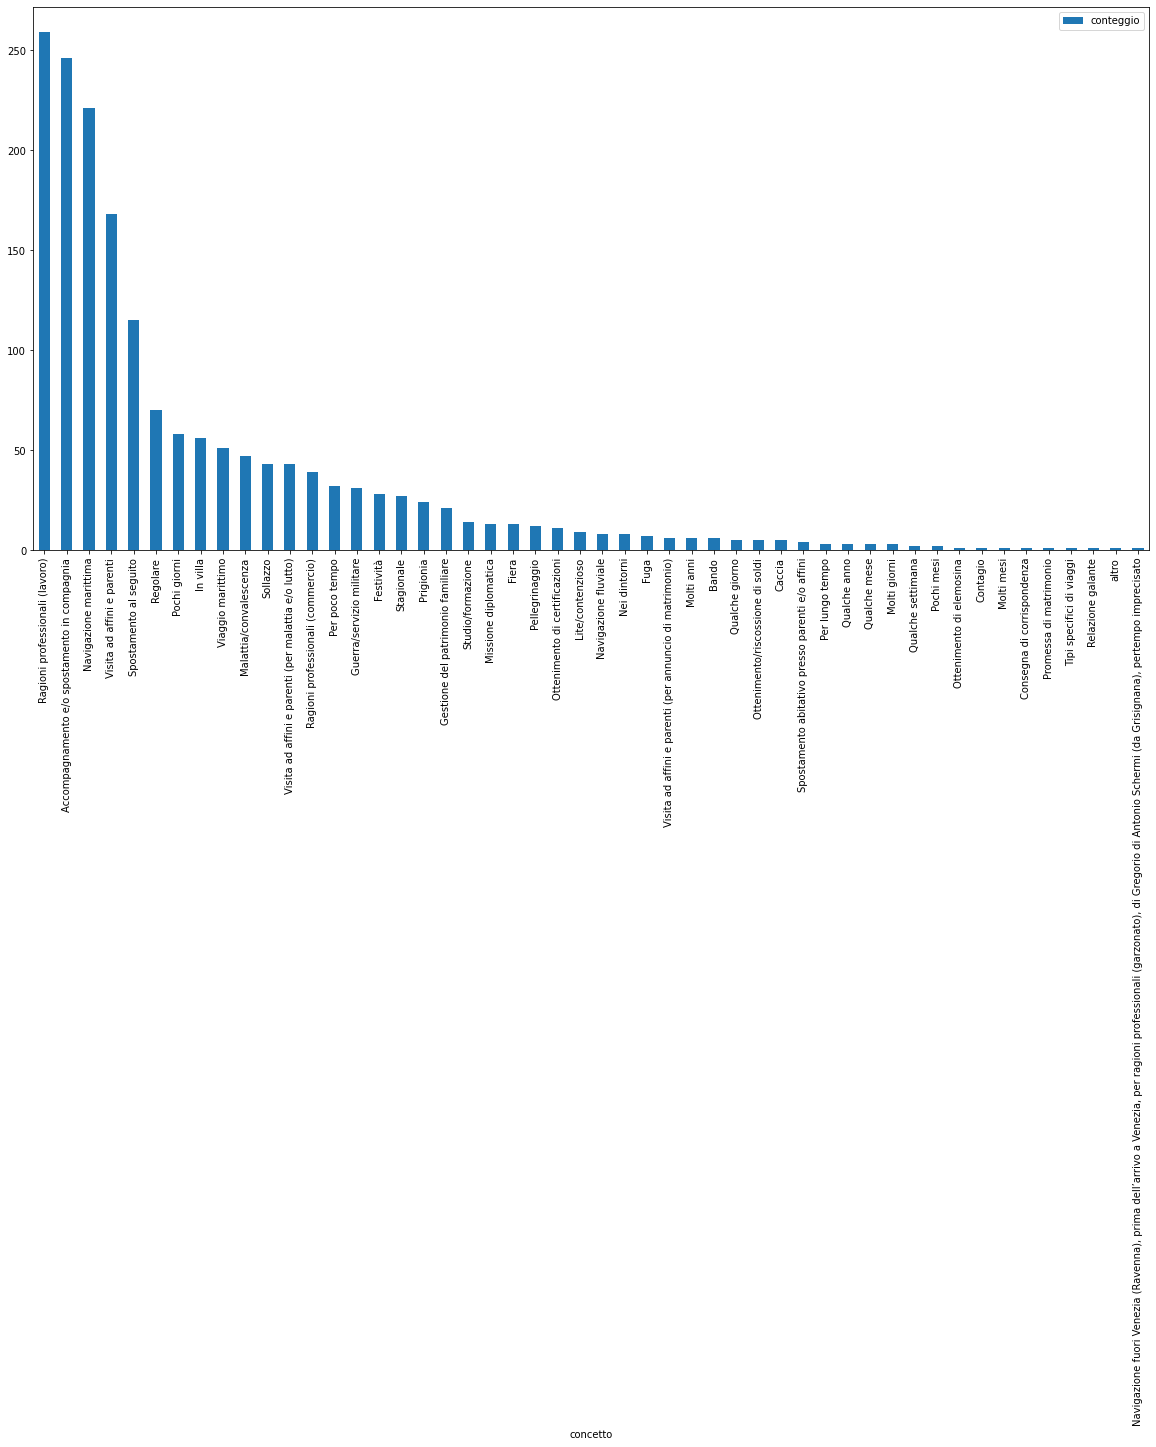

In [ ]:
diz_conc
pd.DataFrame(list(diz_conc.items()),
                   columns=['concetto', 'conteggio']).sort_values(by='conteggio', ascending=False).plot.bar(x = 'concetto', y='conteggio', figsize=(20,10))

In [ ]:
df_account[df_account.concetti]

In [ ]:
## importing matrimoni from Drive

sheet_id = '1FvCURaD66jA4xAa58isbRNVVUpR2AIoaks8Jy37b04w'
sheet_name= 'matrimoni'
url= f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

matrimoni = pd.read_csv(url)

display(matrimoni := matrimoni[['qualità', 'pk_processetto', 'Richiedente', 'Genere',
       'data_processetto', 'data_matrimoni', 'coniuge', 'genere_coniuge',
       'parrocchia_proc', 'parrocchia_matrimonio', 'Unnamed: 10',
       'verifica_testimoni', 'primo_testimone', 'secondo_testimone',
       'corrispondeza', 'note', 'registro_matrimoniale', 'Unnamed: 17',
       'segnatura']])

,qualità,pk_processetto,Richiedente,Genere,data_processetto,data_matrimoni,coniuge,genere_coniuge,parrocchia_proc,parrocchia_matrimonio,Unnamed: 10,verifica_testimoni,primo_testimone,secondo_testimone,corrispondeza,note,registro_matrimoniale,Unnamed: 17,segnatura
0,Richiedente,1624461.0,"Scipione di Vito Pochipanni (da Rovato, rafina...",Maschile,24/02/1603,13/4/1603,"Maddalena Livia di Benedetto Cesana (null, null)",Femminile,S. Croce,S. Geremia,False,"Pietro di Andrea Parisi (da Rovato, savoner) ;...",Pietro di Andrea Parisi,"Giovanni Battista di Giacomo (null, inverardo)",Una,Scipone è testimone al processetto di Paolo di...,"reg. , c.",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
1,Richiedente,759719.0,"Francesca di Pietro Baruffa (bellunese, massera)",Maschile,19/07/1592,13/8/1592,"Girolamo di Michiel Saccon (null, pentor)",Femminile,S. Geremia,S. Geremia,True,Regina vedova di Alessandro De Rubeis ; Giovan...,"Zuan Battista (null, sartor)","Agustin di Rocco (null, samiter)",Nessuna,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
2,Richiedente,764338.0,Battista di Girolamo De Giacomoni (da Cornedo ...,Maschile,02/08/1592,16/9/1592,Franceschina di Francesco d’Alessandro,Femminile,S. Geremia,S. Geremia,True,Giuseppe di Battista Desi (da Barbarano Mossan...,"Giuseppe (null, samiter)","Marc'Antonio (null, samiter)",Una,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
3,Richiedente,1213761.0,"Giovanni Maria di Domenico Blandi (milanese, t...",Maschile,01/09/1594,2/10/1594,"Cecilia di Lunardo (null, testor)",Femminile,S. Geremia,S. Geremia,True,"Baldassarre di Andrea Campini (da Milano, tent...",Baldissera Campini,Francesco di Zuan Maria di Maffei,Una,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
4,Richiedente,1248193.0,"Daniele di Giuliano Giuliani (da San Daniele, ...",Maschile,02/10/1594,11/10/1594,"Cattarina di Piero (da Venezia, null)",Femminile,S. Geremia,S. Geremia,True,"Domenico di Giovanni (da San Daniele, tesser d...","Martin di Bettin (null, testor)","Girolamo di Battista (senese, null)",Una,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Richiedente,1858807.0,"Teodoro Garagna (dalla Riviera di Salò, famulus)",Maschile,28/03/1595,17/5/1598,"Laura vedova Domenico (null, laner)",Femminile,S. Giustina,S. Geremia,False,"Giacomo di Damiano Zagni (da Brescia, laner); ...","Giovanni Battista Colombina (null, servitor)","Gasparo di Medici (null, null)",Nessuna,dubbio,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
84,Richiedente,1081871.0,"Giacomo di Francesco Nicolo (dal Cadore, tesse...",Maschile,NaN,7/2/1599,"Caterina di Giovanni di Nadale (null, testor)",Femminile,S. Geremia,S. Geremia,True,Nicolò di Gaspare Garbeza (da Motta di Livenza...,"aolo (null, damaschiner)","Antonio di Giacomo (null, luganegher)",Nessuna,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
85,Richiedente,989117.0,Angela di Girolamo Pellegrin (da San Vito al T...,Femminile,23/11/1598,16/2/1599,"Domenico di Andrea (padovano, null)",Maschile,S. Marcilian,S. Geremia,False,"Alessandro di Bartolomeo Zotti (da Venezia, sa...","Giovanni di Matteo Vecchin (null, null)",Pietro Rovetta,Nessuna,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."
86,Richiedente,1125472.0,"Paolo di Giuseppe Pois (da Bovegno, samiter)",Maschile,15/04/1599,10/4/1599,"Giulia di Paolo di Anzoli (null, null)",Femminile,S. Geremia,S. Geremia,True,"Maurizio di Comin Zappetti (da Bovegno, vender...","Battista di domenico Serafin (null, null)","Santo di Cosmo (null, testor)",Nessuna,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."


In [ ]:

origine= []
professione = []
a = '('
for e in matrimoni.primo_testimone:    
    if type(e) == str:
        if a in e:
            conto = e.count(a)
    if conto >1:
        print(e)
        display(matrimoni[matrimoni.primo_testimone==e])
            

Giuseppe di di Lorenzo Bellotto (null, null)Lorenzo Contarini (Veneza, patrizio)


,qualità,pk_processetto,Richiedente,Genere,data_processetto,data_matrimoni,coniuge,genere_coniuge,parrocchia_proc,parrocchia_matrimonio,Unnamed: 10,verifica_testimoni,primo_testimone,secondo_testimone,corrispondeza,note,registro_matrimoniale,Unnamed: 17,segnatura
20,Richiedente,1049990.0,"Battista di Pietro Palazzi (da Cornalba, lugan...",Maschile,25/07/1597,12/8/1597,"Elena di Piero di Martin (null, null)",Femminile,S. Geremia,S. Geremia,True,Giovanni Maria di Marco Antonio Bilotti (da Co...,"Giuseppe di di Lorenzo Bellotto (null, null)Lo...","Lorenzo Contarini (Venezia, pratizio)",Nessuna,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."


Martin di Bettin (null, testor) ; Girolamo di Battista (siena ; null)


,qualità,pk_processetto,Richiedente,Genere,data_processetto,data_matrimoni,coniuge,genere_coniuge,parrocchia_proc,parrocchia_matrimonio,Unnamed: 10,verifica_testimoni,primo_testimone,secondo_testimone,corrispondeza,note,registro_matrimoniale,Unnamed: 17,segnatura
62,Testimone,NaN,Daniele di Giovanni Margariti (da San Daniele ...,Maschile,NaN,11/10/1594,"Caterina di Pietro (Venezia, null)",Femminile,NaN,S. Geremia,False,NaN,"Martin di Bettin (null, testor) ; Girolamo di ...",NaN,NaN,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."


Piero (null, fustagner) ; Giuseppe di Pin (null, samiter)


,qualità,pk_processetto,Richiedente,Genere,data_processetto,data_matrimoni,coniuge,genere_coniuge,parrocchia_proc,parrocchia_matrimonio,Unnamed: 10,verifica_testimoni,primo_testimone,secondo_testimone,corrispondeza,note,registro_matrimoniale,Unnamed: 17,segnatura
63,Testimone,NaN,"Antonio di Florio Bragagnini (dalla Carnia, fu...",Maschile,NaN,13/7/1595,"Vienna fi Appolonio (vicenza, null)",Femminile,S. Margherita,S. Geremia,False,NaN,"Piero (null, fustagner) ; Giuseppe di Pin (nul...",NaN,NaN,NaN,"reg. 1, c. nn",NaN,"ASPVe, S. Geremia, Registri dei matrimoni, reg..."


Pietro di Giovanni (null, indorador) ; Perin (null, chierico)


,qualità,pk_processetto,Richiedente,Genere,data_processetto,data_matrimoni,coniuge,genere_coniuge,parrocchia_proc,parrocchia_matrimonio,Unnamed: 10,verifica_testimoni,primo_testimone,secondo_testimone,corrispondeza,note,registro_matrimoniale,Unnamed: 17,segnatura
64,Testimone,NaN,"Giuseppe di Biagio Mozzi (da Flambro, spechier)",Maschile,NaN,8/10/1595,"Elisabetta di Francesco (Vin, null)",Femminile,SS. Apostoli,S. Geremia,False,NaN,"Pietro di Giovanni (null, indorador) ; Perin (...",NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
matrimoni.qualità.value_counts()

Richiedente                  77
Testimone                     8
Possibile identificazione     1
Name: qualità, dtype: int64

In [ ]:
matrimoni.corrispondeza.unique()

array(['Una', 'Nessuna', nan, 'Due'], dtype=object)

In [ ]:
matrimoni[matrimoni].corrispondeza.value_counts()

Nessuna    58
Una        15
Due         2
Name: corrispondeza, dtype: int64